### Data analysis

#### Data exploration

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# d = pd.read_csv('complaint_severity_data (1).csv', header=None, names=['id', 'text', 'binary_label','label', 'domain'])
# d[d['label']==4].iloc[6,1]

In [2]:
# Read data
binary_data = pd.read_csv('complaints-data.csv', header=None, names=['id', 'text', 'binary_label', 'domain'])
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3449 entries, 0 to 3448
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3449 non-null   int64 
 1   text          3449 non-null   object
 2   binary_label  3449 non-null   int64 
 3   domain        3449 non-null   object
dtypes: int64(2), object(2)
memory usage: 107.9+ KB


In [4]:
binary_data.sample(5)

id                                               text  \
1453  937690996086853632  @DIRECTVService He is 93 and needs more help f...   
478   869248658079985664  @SqSupportUK Ok, so when will the 1% transacti...   
1706  940370834648023040  I bought a sprite from mcdonalds and they gave...   
2607  952947288678297600           @JetBlue your killing me with the delays   
440   857507918924656640                     @johnjnorris @SquareUK Classic   

      binary_label     domain  
1453             0   services  
478              1   software  
1706             1       food  
2607             1  transport  
440              0   software

Count for text contain complaint: 1232
Count for text NOT contain complaint: 2217


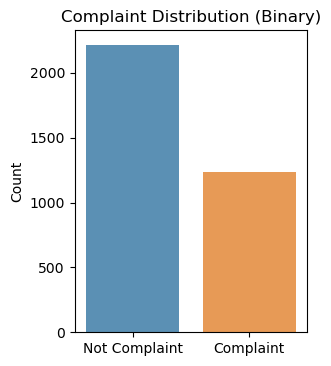

In [5]:
# plot data distribution
bi_count = binary_data.binary_label.value_counts()
plt.figure(figsize=(3,4),dpi=100)
sns.barplot(x=['Not Complaint','Complaint'],y=bi_count.values, alpha=0.8)
plt.title("Complaint Distribution (Binary)")
plt.ylabel('Count')
plt.savefig('data distribution')

print('Count for text contain complaint:',bi_count[1])
print('Count for text NOT contain complaint:',bi_count[0])

In [6]:
# Domain analysis
com_do_count = binary_data[binary_data["binary_label"]==1].domain.value_counts()
noncom_do_count = binary_data[binary_data["binary_label"]==0].domain.value_counts()

domain_list=list(set(binary_data["domain"].values))

domain_count_df=pd.concat([pd.DataFrame(com_do_count),pd.DataFrame(noncom_do_count)],axis=1)
domain_count_df.reset_index(inplace=True)
domain_count_df.columns=['domain','Complaint count','Not complaint count']
domain_count_df['Complaint count']=domain_count_df['Complaint count'].fillna(0)
domain_count_df['sum']=domain_count_df['Complaint count']+domain_count_df['Not complaint count']
domain_count_df
domain_count_df_1 = domain_count_df[:-2]
domain_count_df

domain  Complaint count  Not complaint count    sum
0       services            205.0                  131  336.0
1       software            190.0                  102  292.0
2    electronics            176.0                  114  290.0
3        apparel            145.0                  117  262.0
4      transport            138.0                  109  247.0
5         retail            122.0                   76  198.0
6          other             95.0                   33  128.0
7           food             93.0                   35  128.0
8           cars             68.0                   25   93.0
9   random_reply              0.0                  739  739.0
10  random_tweet              0.0                  736  736.0

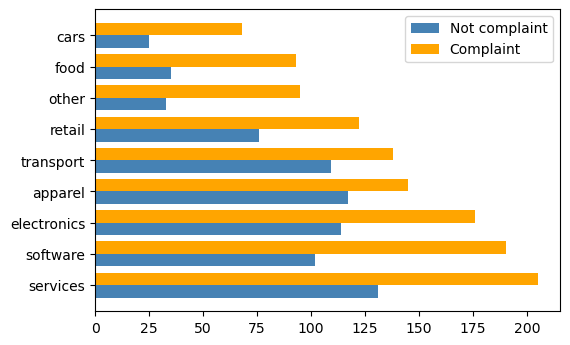

In [7]:
# Plot domian distribution
x = np.arange(len(domain_count_df_1['domain'].values.tolist()))
fig = plt.figure(figsize=(6,4),dpi=100)
plt.barh(x-0.2,domain_count_df_1['Not complaint count'].values.tolist(),0.4,label='Not complaint',color='steelblue')
plt.barh(x+0.2,domain_count_df_1['Complaint count'].values.tolist(),0.4,label='Complaint',color='orange')
plt.yticks(x,domain_count_df_1['domain'].values.tolist())
plt.legend()
plt.savefig('domain distribution')

D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


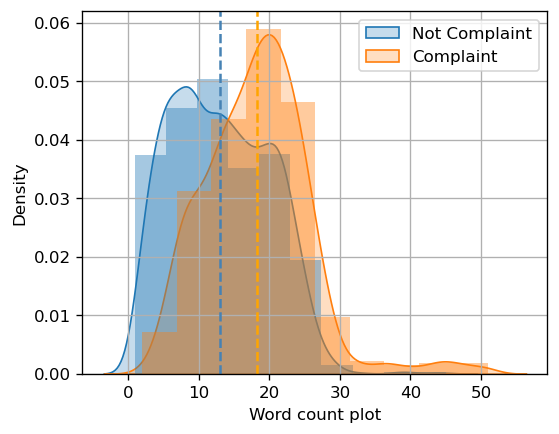

Not complaint word length: 13.046910239061795
Complaint word length: 18.24025974025974


<Figure size 432x288 with 0 Axes>

In [8]:
##word count
binary_data['word_count'] = binary_data["text"].apply(lambda x: len(str(x).split(" ")))

avg_1 = np.average(binary_data[binary_data['binary_label']==1]['word_count'])
avg_0 = np.average(binary_data[binary_data['binary_label']==0]['word_count'])
x, y = "word_count", "binary_label"

fig = plt.figure(figsize=(5,4),dpi=120)

for i in binary_data[y].unique():

    sns.distplot(binary_data[binary_data[y]==i][x], hist=True, kde = True, 
                 bins=10, kde_kws={"shade":True}, 
                 axlabel="Word count plot")
plt.grid(True)
plt.legend(['Not Complaint','Complaint'])
plt.axvline(x=avg_0,linestyle='--',color='steelblue')
plt.axvline(x=avg_1,linestyle='--',color = 'orange')
plt.show()
plt.savefig('word count plot')


print('Not complaint word length:',avg_0)
print('Complaint word length:',avg_1)

#### Text clean (DF)

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Li
[nltk_data]     Jingyi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def text_preprocessor(text,remove_punct,stemming,lemmatization,stop_words,print_progress):
    
    if print_progress == True:
        print('original text:\n',text) 
  
    ## Clean
    text = text.lower()
    
    if remove_punct == True:
#         text = re.sub(r"\@\w+|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?","",text)  # Remove punck/URL/@XXX
        text = re.sub(r"(@\[A-Za-z0-9])+|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text) #  Remove punck/URL/@(remain_username)

    if print_progress is True:
        print('clean text:\n',text) 
        
    txt = text.split()
    
    ## preprocess
    if stemming == True:
        st = nltk.stem.porter.PorterStemmer()
        txt =[st.stem(word) for word in txt]
        if print_progress is True:
            print('stemmed text:\n',txt) 
        
    if lemmatization == True:
        le = nltk.stem.wordnet.WordNetLemmatizer()
        txt = [le.lemmatize(word) for word in txt]
        if print_progress is True:
            print('lemmatization text:\n',txt) 
        
    if stop_words == True:
        stop_words = nltk.corpus.stopwords.words('english')
        txt = [word for word in txt if word not in stop_words]
        if print_progress is True:
            print('removed stop words text:\n',txt) 
            
    
    text = " ".join(txt)  
    
    if print_progress is True:
        print('Cleaning Result:\n', text)
        
    
    return text

def preprocessor_df(data,col,remove_punct,stemming,lemmatization,stop_words,print_progress):
    df = data.copy()
    
    df[col+"_clean"] = df[col].apply(lambda x:text_preprocessor(x,remove_punct,stemming,lemmatization,stop_words,print_progress))
    
    return df

bi_clean_data = preprocessor_df(binary_data,"text",True,True,True,True,False)

In [11]:
#eg
c=text_preprocessor(binary_data['text'].iloc[23],True,True,True,True,True)

original text:
 .@nvidiacc @NVIDIAQuadro CUDA driver Lion update, please? http://t.co/cil6HT1
clean text:
 nvidiacc nvidiaquadro cuda driver lion update please 
stemmed text:
 ['nvidiacc', 'nvidiaquadro', 'cuda', 'driver', 'lion', 'updat', 'pleas']
lemmatization text:
 ['nvidiacc', 'nvidiaquadro', 'cuda', 'driver', 'lion', 'updat', 'plea']
removed stop words text:
 ['nvidiacc', 'nvidiaquadro', 'cuda', 'driver', 'lion', 'updat', 'plea']
Cleaning Result:
 nvidiacc nvidiaquadro cuda driver lion updat plea


In [12]:
#eg
text_preprocessor(binary_data['text'].iloc[201],True,False,False,True,True)

original text:
 @VW #VWCares , funny I don't feel like you do. Car still in shop. Letter not mailed to me yet that was generated on April 18th #notfeelingit
clean text:
 vw vwcares  funny i dont feel like you do car still in shop letter not mailed to me yet that was generated on april 18th notfeelingit
removed stop words text:
 ['vw', 'vwcares', 'funny', 'dont', 'feel', 'like', 'car', 'still', 'shop', 'letter', 'mailed', 'yet', 'generated', 'april', '18th', 'notfeelingit']
Cleaning Result:
 vw vwcares funny dont feel like car still shop letter mailed yet generated april 18th notfeelingit


'vw vwcares funny dont feel like car still shop letter mailed yet generated april 18th notfeelingit'

In [13]:
bi_clean_data

id                                               text  \
0      22631081115127808  @FC_HELP can I return online purchases to a Ho...   
1      23364081385734144  @FC_Help Hi - I'm writing a piece for MSN Him ...   
2      25550410899005441                @FC_Help   i need to check my order   
3      29494955818876928  @FC_Help I need to get in contact with someone...   
4      32523695972945920  @FC_Help How can I get a hold of you so we can...   
...                  ...                                                ...   
3444  961277564063948800  @AmazonHelp You did not upload the ep14 of Mid...   
3445  961280617890578432  @AmazonHelp i have a echo &amp; dot but one st...   
3446  961285418498043904                  @AmazonHelp I have. Please check.   
3447  961286879663480832  Somebody stole my Amazon package off my porch ...   
3448  961287047267807232  @AmazonHelp @C4EAsh give the timeline by which...   

      binary_label   domain  word_count  \
0                0  apparel          21   
1                0  apparel          26   
2                0  apparel           9   
3                1  apparel          25   
4                0  apparel          21   
...            ...      ...         ...   
3444             1   retail          16   
3445             1   retail          21   
3446             0   retail           5   
3447             1   retail          10   
3448             1   retail          20   

                                             text_clean  
0     fchelp return onlin purchas hous fraser conces...  
1     fchelp hi im write piec msn wonder could talk ...  
2                               fchelp need check order  
3     fchelp need get contact someon regard fccom we...  
4            fchelp get hold discus problem havnig coat  
...                                                 ...  
3444      amazonhelp upload ep14 middl seri s9 wa delet  
3445  amazonhelp echo amp dot one stop work say stre...  
3446                              amazonhelp plea check  
3447       somebodi stole amazon packag porch yesterday  
3448  amazonhelp c4eash give timelin ill receiv cash...  

[3449 rows x 6 columns]

In [14]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Li Jingyi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to C:\Users\Li
[nltk_data]     Jingyi\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [15]:
#example
t= bi_clean_data['text'].iloc[20].split()
pos = nltk.pos_tag(t,tagset='universal',lang='eng')
pos

[('@FC_Help', 'NOUN'),
 ('is', 'VERB'),
 ('it', 'PRON'),
 ('possible', 'ADJ'),
 ('to', 'PRT'),
 ('exchange', 'VERB'),
 ('a', 'DET'),
 ('French', 'ADJ'),
 ('Connection', 'NOUN'),
 ('dress', 'NOUN'),
 ('bought', 'VERB'),
 ('in', 'ADP'),
 ('John', 'NOUN'),
 ('Lewis', 'NOUN'),
 ('in', 'ADP'),
 ('your', 'PRON'),
 ('store?', 'NOUN')]

In [16]:
def ner(text):
    pos = nltk.pos_tag(text.split(),tagset='universal',lang='eng')
    return pos

bi_ner_df = bi_clean_data.copy()

bi_ner_df['pos'] = bi_ner_df['text'].apply(lambda x:ner(x))
bi_ner_df 

id                                               text  \
0      22631081115127808  @FC_HELP can I return online purchases to a Ho...   
1      23364081385734144  @FC_Help Hi - I'm writing a piece for MSN Him ...   
2      25550410899005441                @FC_Help   i need to check my order   
3      29494955818876928  @FC_Help I need to get in contact with someone...   
4      32523695972945920  @FC_Help How can I get a hold of you so we can...   
...                  ...                                                ...   
3444  961277564063948800  @AmazonHelp You did not upload the ep14 of Mid...   
3445  961280617890578432  @AmazonHelp i have a echo &amp; dot but one st...   
3446  961285418498043904                  @AmazonHelp I have. Please check.   
3447  961286879663480832  Somebody stole my Amazon package off my porch ...   
3448  961287047267807232  @AmazonHelp @C4EAsh give the timeline by which...   

      binary_label   domain  word_count  \
0                0  apparel          21   
1                0  apparel          26   
2                0  apparel           9   
3                1  apparel          25   
4                0  apparel          21   
...            ...      ...         ...   
3444             1   retail          16   
3445             1   retail          21   
3446             0   retail           5   
3447             1   retail          10   
3448             1   retail          20   

                                             text_clean  \
0     fchelp return onlin purchas hous fraser conces...   
1     fchelp hi im write piec msn wonder could talk ...   
2                               fchelp need check order   
3     fchelp need get contact someon regard fccom we...   
4            fchelp get hold discus problem havnig coat   
...                                                 ...   
3444      amazonhelp upload ep14 middl seri s9 wa delet   
3445  amazonhelp echo amp dot one stop work say stre...   
3446                              amazonhelp plea check   
3447       somebodi stole amazon packag porch yesterday   
3448  amazonhelp c4eash give timelin ill receiv cash...   

                                                    pos  
0     [(@FC_HELP, NOUN), (can, VERB), (I, PRON), (re...  
1     [(@FC_Help, NOUN), (Hi, NOUN), (-, .), (I'm, N...  
2     [(@FC_Help, NOUN), (i, NOUN), (need, VERB), (t...  
3     [(@FC_Help, NOUN), (I, PRON), (need, VERB), (t...  
4     [(@FC_Help, VERB), (How, ADV), (can, VERB), (I...  
...                                                 ...  
3444  [(@AmazonHelp, NOUN), (You, PRON), (did, VERB)...  
3445  [(@AmazonHelp, NOUN), (i, NOUN), (have, VERB),...  
3446  [(@AmazonHelp, NOUN), (I, PRON), (have., VERB)...  
3447  [(Somebody, NOUN), (stole, ADJ), (my, PRON), (...  
3448  [(@AmazonHelp, NOUN), (@C4EAsh, NOUN), (give, ...  

[3449 rows x 7 columns]

#### Sentiment features

In [17]:
# vader sentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
bi_clean_data["vader_sentiment"] = bi_clean_data["text"].apply(lambda x: analyzer.polarity_scores(x)['compound'])


D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


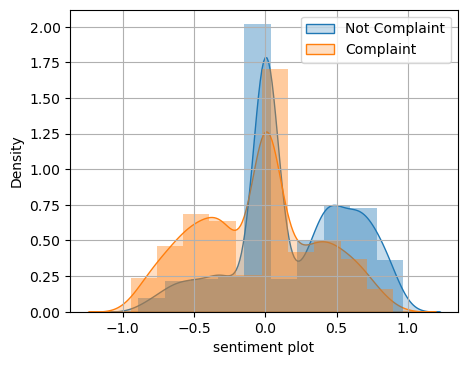

In [18]:
x, y = "vader_sentiment", "binary_label"
plt.figure(figsize=(5,4),dpi=100)
for i in binary_data[y].unique():

    sns.distplot(bi_clean_data[bi_clean_data[y]==i][x], hist=True, kde = True, 
                 bins=10, kde_kws={"shade":True}, 
                 axlabel="sentiment plot")
    
plt.grid(True)
plt.legend(['Not Complaint','Complaint'])
plt.savefig('sentiment plot 1')

D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\python\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


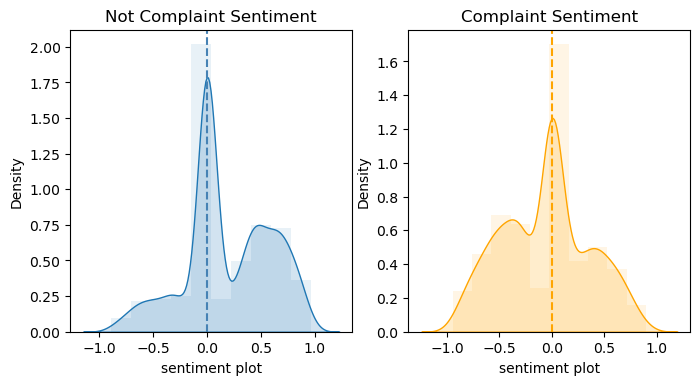

<Figure size 432x288 with 0 Axes>

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8,4),dpi=100)

ax[0].set(title="Not Complaint Sentiment")


sns.distplot(bi_clean_data[bi_clean_data['binary_label']==0]['vader_sentiment'], hist=True, kde = True, 
                 bins=10, kde_kws={"shade":True,"alpha": 0.2}, hist_kws={"alpha": 0.1}
                 ,axlabel="sentiment plot",ax=ax[0])
# ax[0].hist(bi_clean_data[bi_clean_data['binary_label']==0]['vader_sentiment'], color='black',width=0.12)
# ax[0].set_xlabel('Sentiment')
# ax[0].set_ylabel('Freqency', color='black')

ax[1].set(title="Complaint Sentiment")
sns.distplot(bi_clean_data[bi_clean_data['binary_label']==1]['vader_sentiment'], hist=True, kde = True, 
                 bins=10, kde_kws={"shade":True,"alpha": 0.2,"color":"orange"}, hist_kws={"alpha": 0.1,"color":"orange"}
                 ,axlabel="sentiment plot",ax=ax[1])


# ax[1].hist(bi_clean_data[bi_clean_data['binary_label']==1]['vader_sentiment'], color='steelblue',width=0.12)
# ax[1].set_xlabel('Sentiment')
# ax[1].set_ylabel('Frequency', color='black')
ax[0].axvline(x=0,linestyle='--',color='steelblue')
ax[1].axvline(x=0,linestyle='--',color = 'orange')

plt.show()
plt.savefig('sentiment plot 2')

#### Word frequency analysis

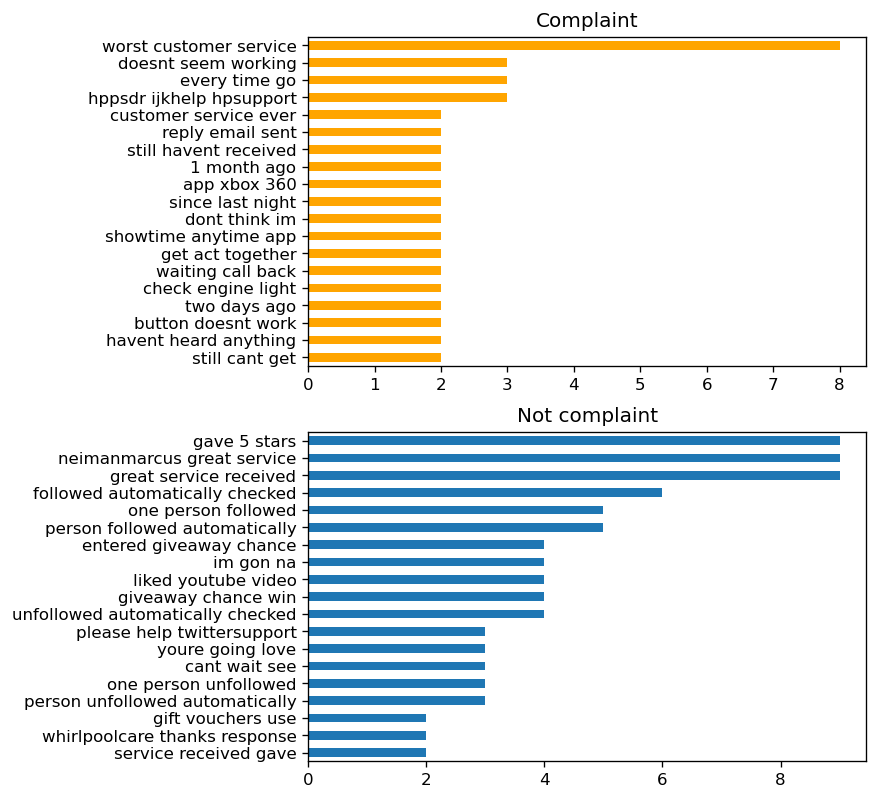

In [20]:
wf_df = preprocessor_df(binary_data,"text",True,False,False,True,False)

corpus_1 = wf_df[wf_df["binary_label"]==1]["text_clean"]
tokens_1 = nltk.tokenize.word_tokenize(corpus_1.str.cat(sep=" "))
dic_frq_1 = nltk.FreqDist(nltk.ngrams(tokens_1,3))
df_1 = pd.DataFrame(dic_frq_1.most_common(),columns=['ngram','Freq'])
df_1["ngram"] = df_1["ngram"].apply(lambda x: " ".join(string for string in x))

corpus_0 = wf_df[wf_df["binary_label"]==0]["text_clean"]
tokens_0 = nltk.tokenize.word_tokenize(corpus_0.str.cat(sep=" "))
dic_frq_0 = nltk.FreqDist(nltk.ngrams(tokens_0,3))
df_0 = pd.DataFrame(dic_frq_0.most_common(),columns=['ngram','Freq'])
df_0["ngram"] = df_0["ngram"].apply(lambda x: " ".join(string for string in x))

fig,ax = plt.subplots(nrows = 2,ncols = 1,figsize=(6, 8),dpi=120)


df_1.set_index("ngram").iloc[0:19].sort_values(by = "Freq").plot(kind = "barh",title = "Complaint",ax=ax[0],legend = False,color='orange')
ax[0].set(ylabel=None)

df_0.set_index("ngram").iloc[0:19].sort_values(by = "Freq").plot(kind = "barh",title = "Not complaint",ax=ax[1],legend = False)
ax[1].set(ylabel=None)

plt.savefig('word count tfftf trigram')

In [21]:
def wf(domain_item,binary_label,ngram):
    corpus = wf_df[(wf_df.domain==domain_item)&(wf_df.binary_label==binary_label)]["text_clean"]
    tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    dic_frq = nltk.FreqDist(nltk.ngrams(tokens,ngram))
    df = pd.DataFrame(dic_frq.most_common(),columns=['ngram','Freq'])
    df["ngram"] = df["ngram"].apply(lambda x: " ".join(string for string in x))
    return df

In [22]:
com_wf_df=pd.concat([wf("services",1,2).iloc[0:20],wf("apparel",1,2).iloc[0:20],wf("retail",1,2).iloc[0:20],wf("software",1,2).iloc[0:20],wf("electronics",1,2).iloc[0:20],wf("transport",1,2).iloc[0:20]],axis=1)
com_wf_df.columns=['Services','Freq','Apparel','Freq','Retail','Freq','Software','Freq','Electronics','Freq','Transport','Freq']
com_wf_df

Services  Freq              Apparel  Freq  \
0                customer service     6     customer service     8   
1                   still waiting     5         placed order     5   
2                        cant get     4       worst customer     4   
3                        pay bill     4             days ago     3   
4              aol aolsupporthelp     4      tracking number     3   
5                       dont know     3              1 month     3   
6                   email address     3        still waiting     3   
7                      since last     3            order yet     3   
8                     please help     3  asosheretohelp asos     3   
9                       need help     3    asosheretohelp hi     3   
10                    whats going     3             next day     3   
11                         3 days     3           back stock     2   
12                    internet tv     3            fchelp hi     2   
13           kenyapowercare power     3     express delivery     2   
14                        south b     3       received email     2   
15            nationalgridus bill     2           hes racist     2   
16  nationalgridus nationalgridus     2            month ago     2   
17                     phone line     2           debit card     2   
18                   power outage     2           waste time     2   
19                    help please     2         cyber monday     2   

                    Retail  Freq          Software  Freq  \
0         customer service     6  shohelp showtime     5   
1               back stock     4      shohelp cant     3   
2           received email     3          apple tv     3   
3               many times     3  showtime anytime     3   
4                call back     3  customer service     3   
5             still havent     2        every time     3   
6   harrodsservice harrods     2      showtime app     3   
7              please help     2   stopped working     3   
8            lost business     2     email account     3   
9           please provide     2        hey medium     3   
10        ikeauksupport hi     2    support ticket     3   
11    thanks ikeauksupport     2     server errors     2   
12               ikeauk hi     2          app xbox     2   
13          bestbuy placed     2          xbox 360     2   
14            placed order     2      keep getting     2   
15           askebay still     2       anytime app     2   
16           askebay hello     2           4 times     2   
17               dont know     2    claim business     2   
18              havent yet     2  yelpsupport yelp     2   
19    ikeauk ikeauksupport     2        still cant     2   

                 Electronics  Freq                     Transport  Freq  
0             hppsdr ijkhelp     7  railminindia piyushgoyaloffc     3  
1                please help     6                      dear sir     3  
2          ijkhelp hpsupport     4                booking number     2  
3   oneplusin oneplussupport     4         airasiasupport please     2  
4                   g5s plus     3                      check dm     2  
5            software update     3                 change flight     2  
6               support site     3                  minutes late     2  
7       lenovosupport lenovo     2                     need help     2  
8                    2 hours     2              customer service     2  
9        phone lenovosupport     2                 sitting plane     2  
10                  cant get     2                     six hours     2  
11                   2 weeks     2                  check online     2  
12                  wont get     2          britishairways would     2  
13                  get past     2          britishairways still     2  
14          charging working     2                      hrs late     2  
15               ive already     2           euston virgintrains     2  
16               worst phone     2          working 

### Model

#### Pretrain embedding

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn.feature_selection import chi2
from sklearn.metrics import *
import time
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
# nltk.download('punkt')
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
np.random.seed(42)
tf.random.set_seed(42)

In [132]:
def take_corpus(X):
    ngram = []
    for doc in range(len(X)):
        wds = X.values[doc].split()
        ngram.append(wds)
    return ngram
    
train_corpus = take_corpus(df_train["text_clean"])
test_corpus = take_corpus(df_test["text_clean"])

# Word2Vec 
# Initialize and train the model #input with [[w1,w2,w3...],[w1,w2,w3...]] format
w2v_model = Word2Vec(train_corpus,vector_size=300,min_count=10,sg=1)

model_name = "word2vec"
w2v_model.save(model_name)
print("----------model saved------------------")

w2v_model = Word2Vec.load("word2vec")
#model.wv['return']

print("----------model loaded-----------------")

print("most similar word with 'return'")
print(w2v_model.wv.most_similar('return', topn=10))
print("most similar word with 'order'")
print(w2v_model.wv.most_similar('order', topn=10))

word_vectors = w2v_model.wv
word_vectors.save("word2vec.wordvectors")

# Load back vector
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
# wv['online']

w2v = dict(zip(w2v_model.wv.index_to_key, w2v_model.wv.vectors))
# w2v["a"]

# create matrix of embedding
w2v_embeddings = np.zeros((len(bow_vocab)+1, 300))
for word,idx in bow_vocab.items():
    try:
        w2v_embeddings[idx] =  w2v[word]
    except:
        pass

----------model saved------------------
----------model loaded-----------------
most similar word with 'return'
[('appl', 0.9994317889213562), ('thank', 0.9994268417358398), ('contact', 0.9994108080863953), ('buy', 0.9994043707847595), ('1', 0.9994016289710999), ('longer', 0.9993835687637329), ('open', 0.9993826150894165), ('want', 0.9993806481361389), ('money', 0.9993773102760315), ('miss', 0.9993757009506226)]
most similar word with 'order'
[('ani', 0.9993358850479126), ('month', 0.9993301033973694), ('mani', 0.9993166923522949), ('alreadi', 0.9993149042129517), ('today', 0.9993149042129517), ('someth', 0.9993124604225159), ('onlin', 0.9993111491203308), ('im', 0.9993042349815369), ('put', 0.9993040561676025), ('contact', 0.9993022084236145)]


In [59]:
import gensim.downloader
# glove_25 = gensim.downloader.load('glove-twitter-25')
glove_50 = gensim.downloader.load('glove-twitter-50')

print("most similar word with 'return'")
print(glove_50.most_similar('return', topn=10))
print("most similar word with 'order'")
print(glove_50.most_similar('order', topn=10))

glove = dict(zip(glove_50.index_to_key, glove_50.vectors))

# create matrix of embedding
## start the matrix (length of vocabulary x vector size) with all 0s
glove_embeddings = np.zeros((len(bow_vocab)+1, 300))

for word,idx in bow_vocab.items():
    ## update the row with vector
    try:
        glove_embeddings[idx] =  glove[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

most similar word with 'return'
[('returns', 0.8539408445358276), ('another', 0.8432333469390869), ('returning', 0.840538740158081), ('sign', 0.8357619643211365), ('will', 0.8336567282676697), ('second', 0.823594868183136), ('end', 0.8145602941513062), ('ahead', 0.8125453591346741), ('after', 0.8095148801803589), ('until', 0.8091000914573669)]
most similar word with 'order'
[('free', 0.8413709402084351), ('buy', 0.8015073537826538), ('or', 0.7993525862693787), ('delivery', 0.7909960150718689), ('available', 0.7894341349601746), ('offer', 0.7886397242546082), ('sell', 0.7872159481048584), ('share', 0.7813246846199036), ('save', 0.7783443331718445), ('add', 0.7761794924736023)]


#### eva method

In [92]:
# test
def plot_eva(model,t, X_test, y_test):
    
    predicted_prob = model.predict(X_test)

    predict = np.zeros(len(predicted_prob))
    
    for i in range(len(predicted_prob)):
        if predicted_prob[i] < 0.5:
            predict[i] =0
        else:
            predict[i]=1
            
    accuracy = metrics.accuracy_score(np.array(y_test), predict)
    precision = metrics.precision_score(np.array(y_test), predict)
    recall = metrics.recall_score(np.array(y_test), predict)
    f1 = metrics.f1_score(np.array(y_test), predict,average='macro')
    
    fpr,tpr,thresholds = roc_curve(y_test,predicted_prob)
    
    auc = metrics.auc(fpr,tpr)
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=120)
    
    ConfusionMatrixDisplay.from_predictions(np.array(y_test), predict,ax=ax[0])
    ax[0].set_title(t+' Confusion Matrix Plot')
    ax[1].plot(fpr,tpr,label='AUC=%.2f'% auc )
    ax[1].plot([0,0],[1,1],linestyle='--')
    ax[1].set(xlabel = 'FP rate',ylabel='TP rate')
    ax[1].grid(True)
    ax[1].set_title(t+' ROC-AUC Plot')
    ax[1].legend()
    
    
    plt.savefig(t+'_eva_plot')
    
    print('Accuracy in test: %.3f' % accuracy)
    print('Precision in test: %.3f' % precision)
    print('Recall in test: %.3f' % recall)
    print('F1-Score in test: %.3f' % f1)
    print('auc in test: %.3f' % auc)
    
    eva_list = [accuracy,precision,recall,f1,auc]
    
    return eva_list

def plot_train(t,history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,4),dpi=100)

    ax[0].plot(val_loss,label='validation data loss')
    ax[0].plot(train_loss,label='train data loss')
    
    ax[1].plot(val_acc,label='validation accuracy')
    ax[1].plot(train_acc,label='train accuracy')
    

    ax[0].set(title = t + " loss plot")
    ax[1].set(title = t +' accuracy plot')
    ax[0].legend()
    ax[1].legend()

#### BOW+LR (baseline)

In [267]:
## split the dataset in train and test with 7:3
df_train,df_test = model_selection.train_test_split(bi_clean_data, test_size = 0.3, shuffle = True)

y_train = df_train["binary_label"].values.tolist()
y_test = df_test["binary_label"].values.tolist()

## bow
count_vec = CountVectorizer(ngram_range = (1,1))
tfidf_vec = TfidfVectorizer(ngram_range = (1,1))

bow_corpus = df_train['text_clean']
tfidf_vec.fit(bow_corpus)
X_train_tfidf = tfidf_vec.transform(bow_corpus)
bow_vocab =tfidf_vec.vocabulary_  #{'wd':count}

In [268]:
## Train LR_CV model
lr_param_grid = [{'lr__penalty': ['l1', 'l2','elasticnet'],
               'lr__C': [1.0,0.8,0.9,0.5],
               'lr__max_iter': [10,20,30,40,50],
               'lr__solver':['lbfgs','sag']
              }]

lr_pipeline = Pipeline([('vectorizer', tfidf_vec),('lr', LogisticRegression(random_state=42))])

gs_lr_model = GridSearchCV(lr_pipeline, lr_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

gs_lr_model.fit(df_train['text_clean'], y_train)

lr_best_dict = gs_lr_model.best_params_
lr_best_score = gs_lr_model.best_score_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


D:\python\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "D:\python\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\python\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "D:\python\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\python\lib\site-packages\sklearn\li

In [269]:
lr_best_dict

{'lr__C': 1.0, 'lr__max_iter': 10, 'lr__penalty': 'l2', 'lr__solver': 'sag'}

Accuracy in test: 0.770
Precision in test: 0.833
Recall in test: 0.463
F1-Score in test: 0.717
auc in test: 0.705


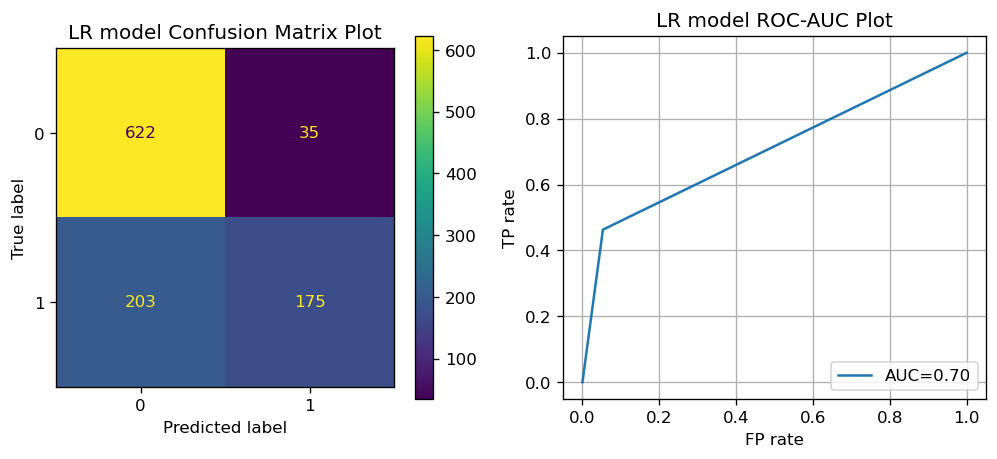

In [270]:
lr_eva_list=plot_eva(gs_lr_model.best_estimator_,'LR model', df_test['text_clean'], y_test)

#### pad sequence for NN

In [197]:
## tf
def pad_seq(tokenizer, X_train,X_test, maxlen,p):
    tokenizer.fit_on_texts(X_train)
    vocab = tokenizer.word_index
    X_train_word_ids = tf_tokenizer.texts_to_sequences(X_train)
    X_test_word_ids = tf_tokenizer.texts_to_sequences(X_test)
    
    X_train_pad = pad_sequences(X_train_word_ids, maxlen=maxlen)
    X_test_pad = pad_sequences(X_test_word_ids, maxlen=maxlen)
    
    X_train_oh = tokenizer.sequences_to_matrix(X_train_word_ids, mode='count')
    X_test_oh = tokenizer.sequences_to_matrix(X_test_word_ids, mode='count')
    
    if p == True:
        
        print('Original clean sentence:\n',df_train['text_clean'].iloc[0])
        print('Covert to id wrt vocabulary:\n',X_train_word_ids[0])
        print('Pad sequence with length=50:\n',X_train_pad[0])
        
    return vocab,X_train_oh,X_test_oh,X_train_pad,X_test_pad


tf_tokenizer = Tokenizer(split=" ")
tf_tokenizer.fit_on_texts(df_train['text_clean'].values.tolist())
vocab = tf_tokenizer.word_index

X_train_word_ids = tf_tokenizer.texts_to_sequences(df_train['text_clean'])
X_test_word_ids = tf_tokenizer.texts_to_sequences(df_test['text_clean'])

X_train_pad = pad_sequences(X_train_word_ids, maxlen=50)
X_test_pad = pad_sequences(X_test_word_ids, maxlen=50)

X_train_oh = tf_tokenizer.sequences_to_matrix(X_train_word_ids, mode='count')
X_test_oh = tf_tokenizer.sequences_to_matrix(X_test_word_ids, mode='count')

print('Original clean sentence:\n',df_train['text_clean'].iloc[0])
print('Covert to id wrt vocabulary:\n',X_train_word_ids[0])
print('Pad sequence with length=50:\n',X_train_pad[0])
    

Original clean sentence:
 medium hide post alreadi publish medium without delet
Covert to id wrt vocabulary:
 [103, 1424, 229, 132, 2069, 103, 271, 593]
Pad sequence with length=50:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  103 1424  229  132 2069  103  271  593]


In [212]:
# one group for hyperparameters tune
vocab_ht,X_train_oh_ht,X_test_oh_ht,X_train_pad_ht,X_test_pad_ht = pad_seq(Tokenizer(split=" "), 
                                                                 df_train['text_clean'].values.tolist(),
                                                                 df_test['text_clean'].values.tolist(), 50,True)
y_train_ht=df_train['binary_label'].values.tolist()
y_test_ht=df_test['binary_label'].values.tolist()

# manual shuffle with cv=5 for repeat 
X=np.array(bi_clean_data['text_clean'].values.tolist())
y=np.array(bi_clean_data['binary_label'].values.tolist())

ss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0) 

X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]
for train_index, test_index in ss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

Original clean sentence:
 medium hide post alreadi publish medium without delet
Covert to id wrt vocabulary:
 [103, 1424, 229, 132, 2069, 103, 271, 593]
Pad sequence with length=50:
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  103 1424  229  132 2069  103  271  593]


In [208]:
len(vocab_ht)

5948

#### MPC 1-layer

Epoch 1/100
61/61 [==============================] - 1s 12ms/step - loss: 0.6860 - accuracy: 0.5992 - val_loss: 0.6776 - val_accuracy: 0.6522
Epoch 2/100
61/61 [==============================] - 1s 11ms/step - loss: 0.6731 - accuracy: 0.6385 - val_loss: 0.6662 - val_accuracy: 0.6542
Epoch 3/100
61/61 [==============================] - 1s 11ms/step - loss: 0.6640 - accuracy: 0.6380 - val_loss: 0.6582 - val_accuracy: 0.6542
Epoch 4/100
61/61 [==============================] - 1s 10ms/step - loss: 0.6577 - accuracy: 0.6375 - val_loss: 0.6526 - val_accuracy: 0.6542
Epoch 5/100
61/61 [==============================] - 1s 11ms/step - loss: 0.6532 - accuracy: 0.6375 - val_loss: 0.6483 - val_accuracy: 0.6542
Epoch 6/100
61/61 [==============================] - 1s 11ms/step - loss: 0.6488 - accuracy: 0.6375 - val_loss: 0.6450 - val_accuracy: 0.6542
Epoch 7/100
61/61 [==============================] - 1s 10ms/step - loss: 0.6457 - accuracy: 0.6375 - val_loss: 0.6421 - val_accuracy: 0.6542
Epoch 

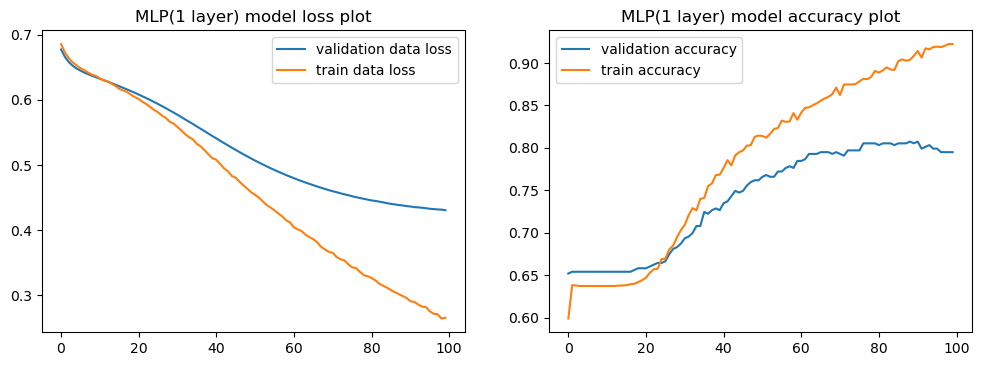

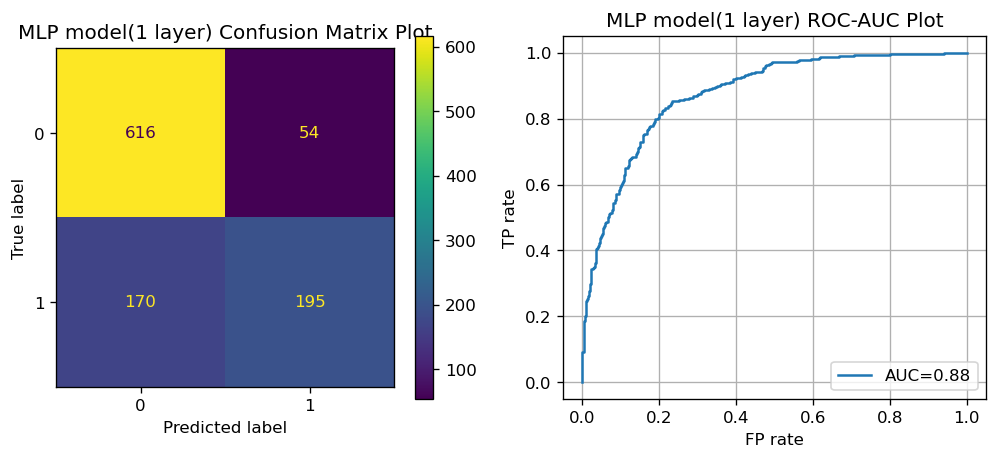

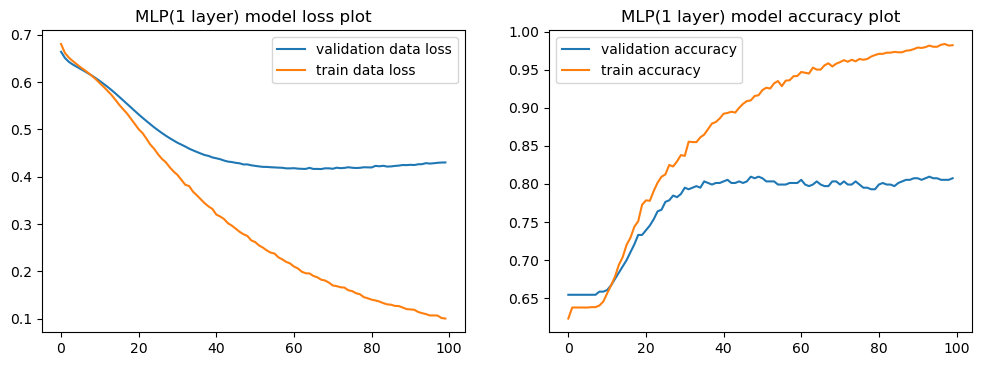

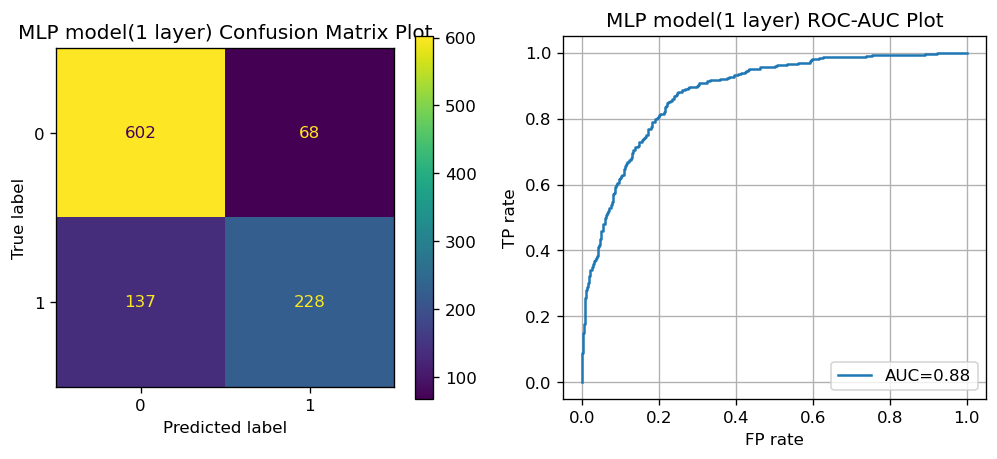

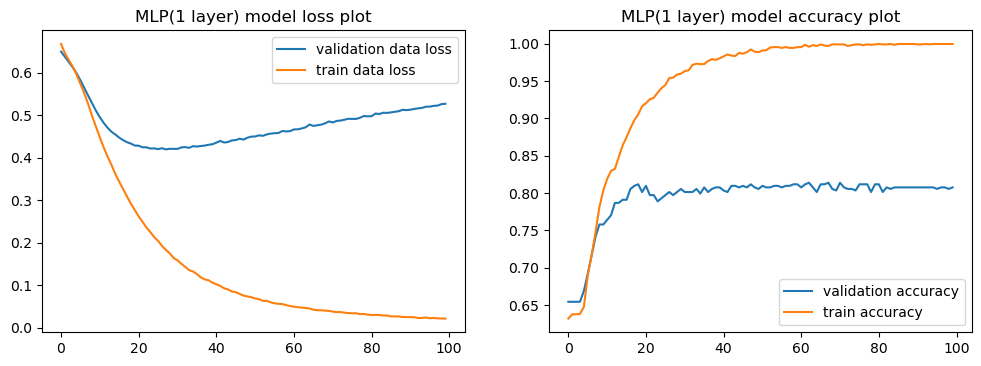

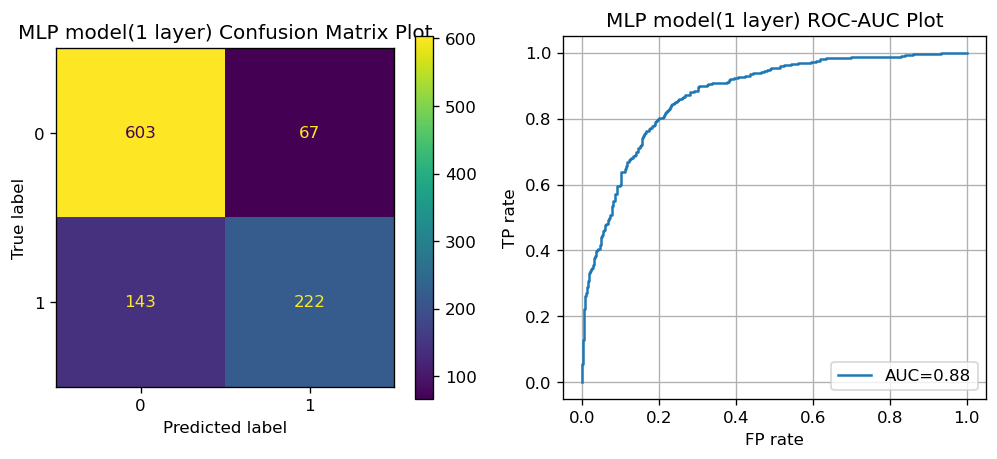

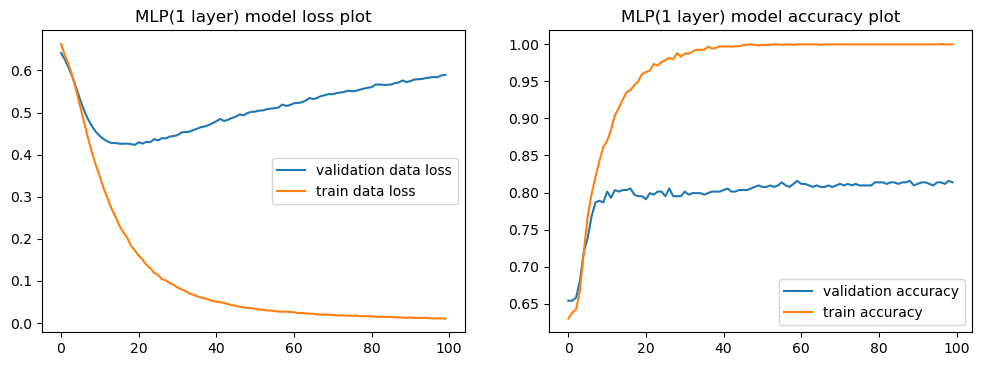

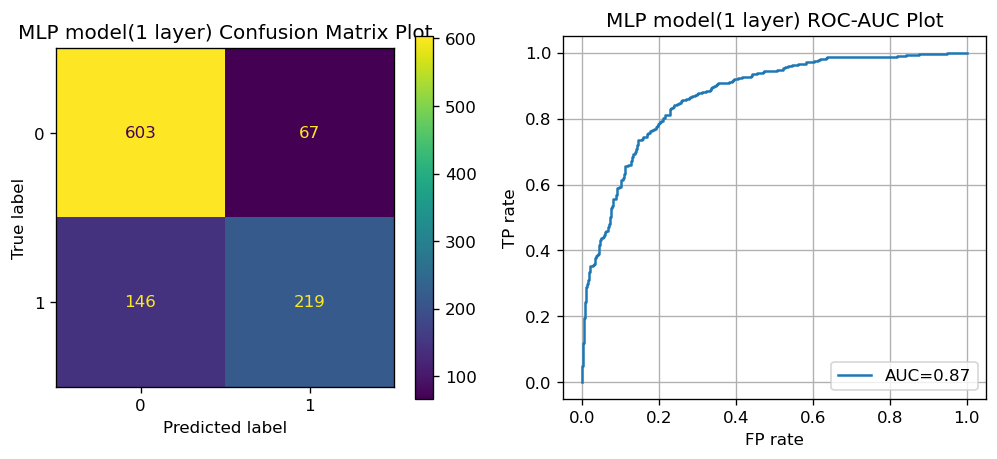

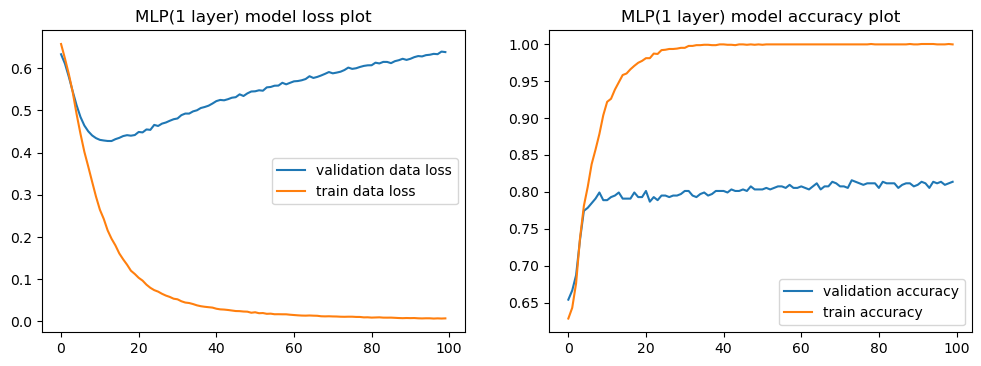

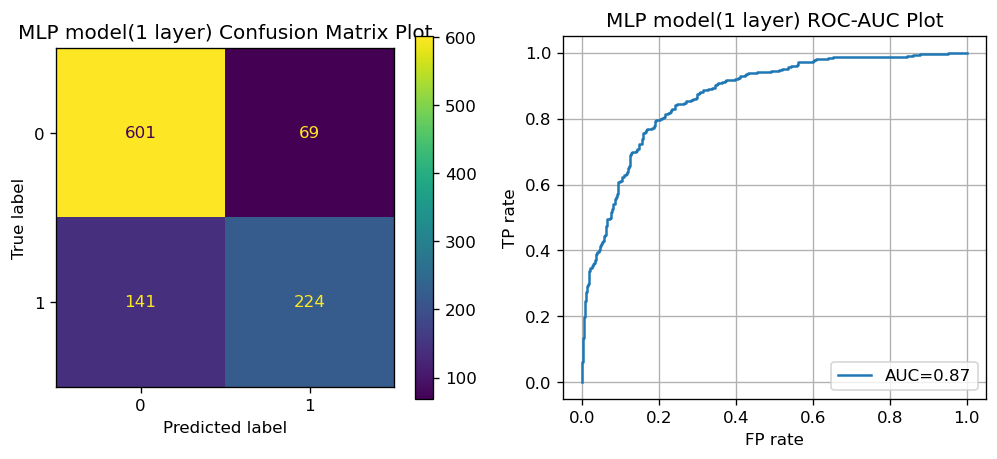

In [213]:
# parameter tune
lr_list_mlp_1 = [0.01,0.02,0.05,0.075,0.1]
mlp_eva_list_ht=[]

for i in range(len(lr_list_mlp_1)):
    #Defind
    mlp_model_1 = keras.models.Sequential()
    mlp_model_1.add(keras.layers.Dense(512, input_shape=(len(vocab_ht)+1,), activation='relu'))
    mlp_model_1.add(keras.layers.Dropout(0.3))
    mlp_model_1.add(keras.layers.Dense(1,activation='sigmoid'))
    #complile
    mlp_model_1.compile(tf.keras.optimizers.SGD(lr=lr_list_mlp_1[i]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    #train
    mlp_history_1=mlp_model_1.fit(X_train_oh_ht, np.array(y_train_ht),
              batch_size=32,
              epochs=100,
              validation_split=0.2)

    # plot train
    plot_train('MLP(1 layer) model',mlp_history_1)
    mlp_eva_list_1= plot_eva(mlp_model_1,'MLP model(1 layer)', X_test_oh_ht, y_test_ht)
    mlp_eva_list_ht.append(mlp_eva_list_1)

In [214]:
# find best lr
print(pd.DataFrame(mlp_eva_list_ht,columns=['Accuracy','Precision','Recall','F1','AUC']))
print('best lr in mlp-1:',lr_list_mlp_1[1])

   Accuracy  Precision    Recall        F1       AUC
0  0.783575   0.783133  0.534247  0.740666  0.877583
1  0.801932   0.770270  0.624658  0.772185  0.882834
2  0.797101   0.768166  0.608219  0.765297  0.876426
3  0.794203   0.765734  0.600000  0.761353  0.872824
4  0.797101   0.764505  0.613699  0.766063  0.873167
best lr in mlp-1: 0.02


Epoch 1/100
61/61 [==============================] - 1s 14ms/step - loss: 0.6775 - accuracy: 0.6370 - val_loss: 0.6639 - val_accuracy: 0.6480
Epoch 2/100
61/61 [==============================] - 1s 14ms/step - loss: 0.6586 - accuracy: 0.6416 - val_loss: 0.6521 - val_accuracy: 0.6480
Epoch 3/100
61/61 [==============================] - 1s 15ms/step - loss: 0.6493 - accuracy: 0.6416 - val_loss: 0.6444 - val_accuracy: 0.6480
Epoch 4/100
61/61 [==============================] - 1s 14ms/step - loss: 0.6413 - accuracy: 0.6416 - val_loss: 0.6386 - val_accuracy: 0.6480
Epoch 5/100
61/61 [==============================] - 1s 15ms/step - loss: 0.6354 - accuracy: 0.6416 - val_loss: 0.6334 - val_accuracy: 0.6480
Epoch 6/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6298 - accuracy: 0.6416 - val_loss: 0.6284 - val_accuracy: 0.6480
Epoch 7/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6225 - accuracy: 0.6416 - val_loss: 0.6232 - val_accuracy: 0.6480
Epoch 

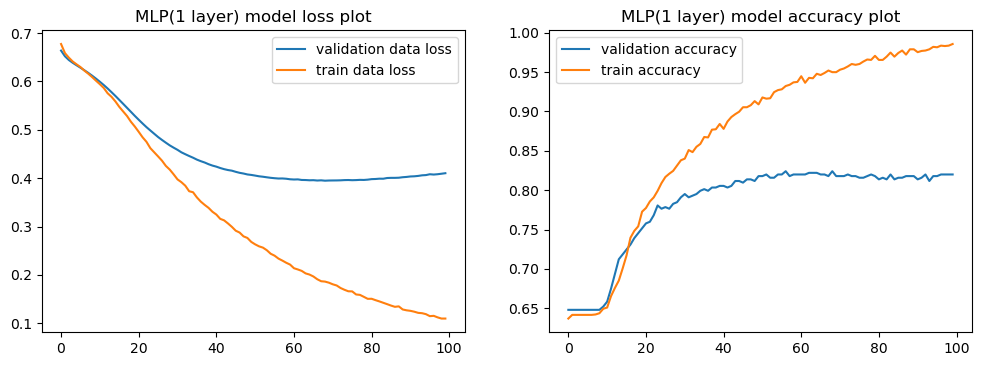

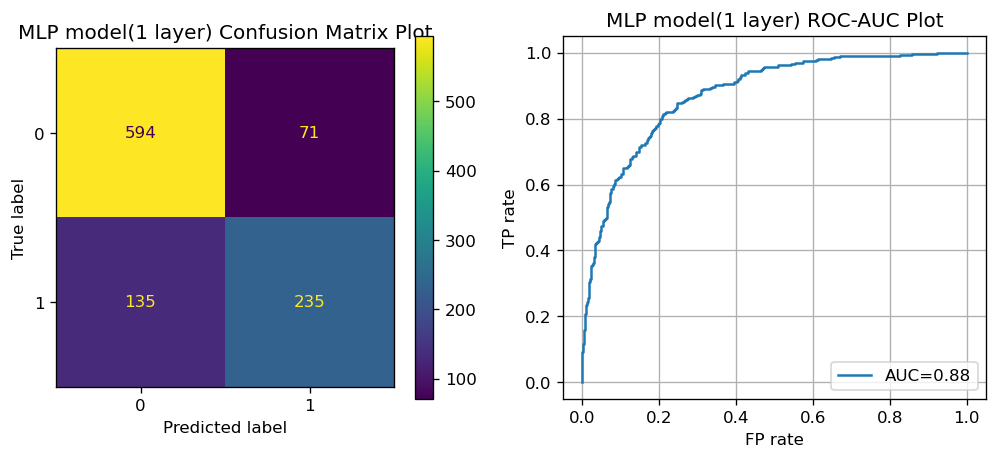

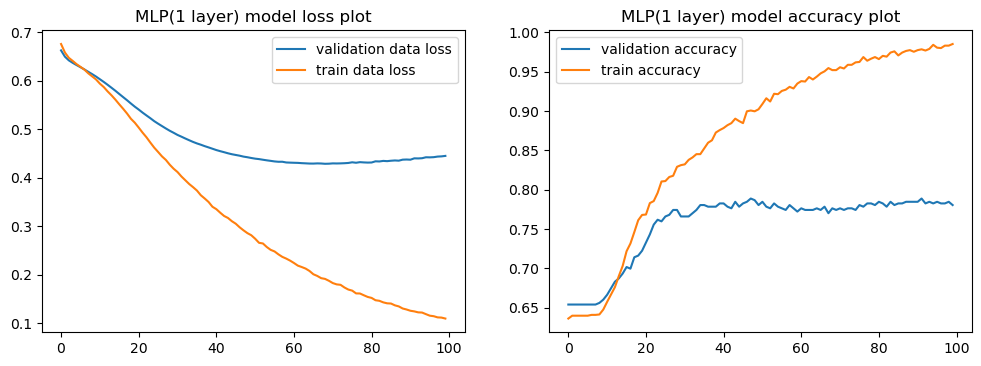

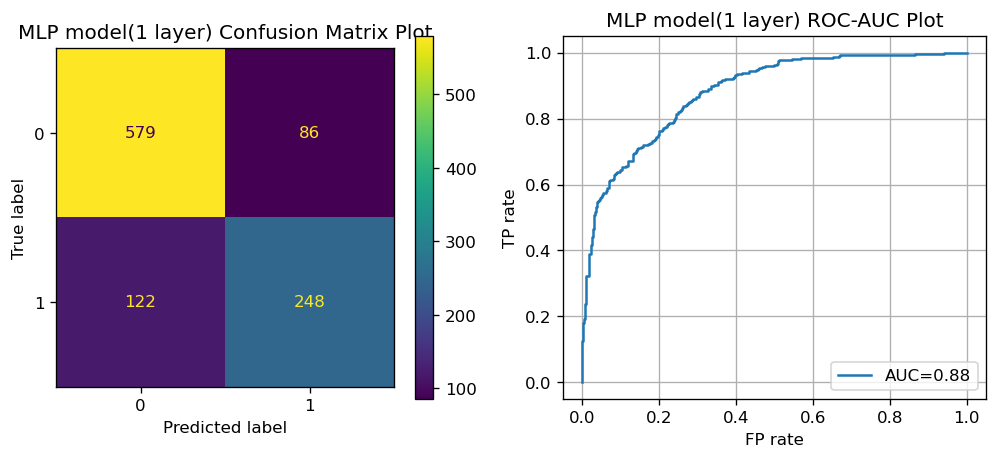

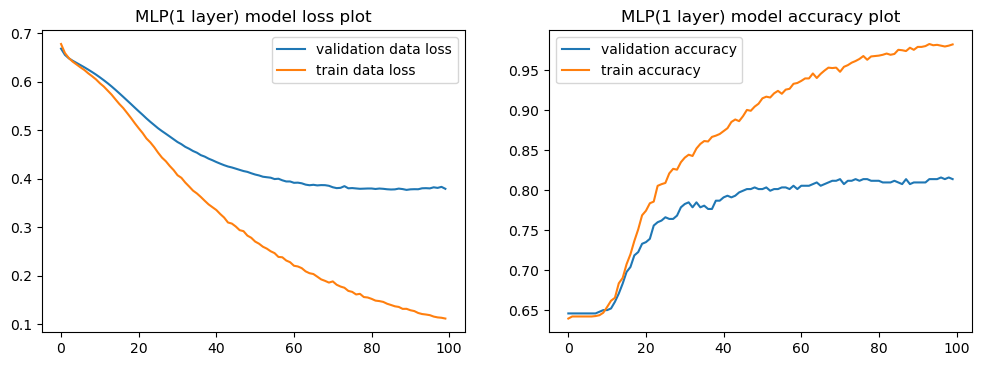

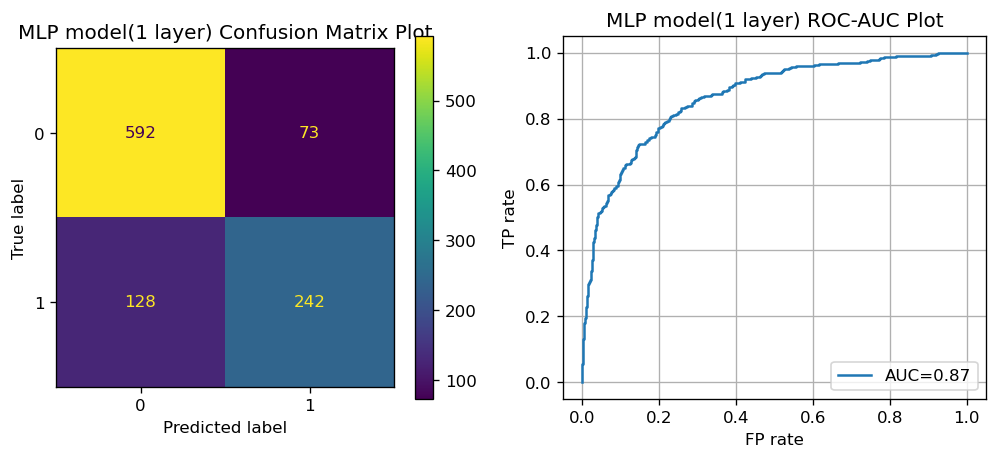

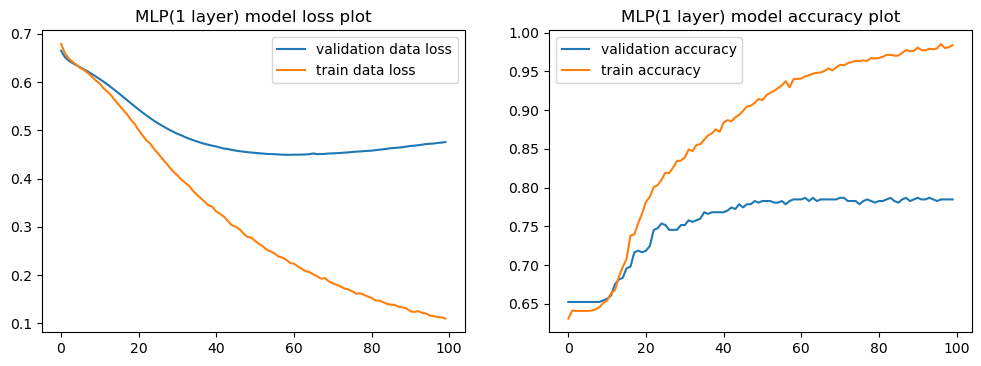

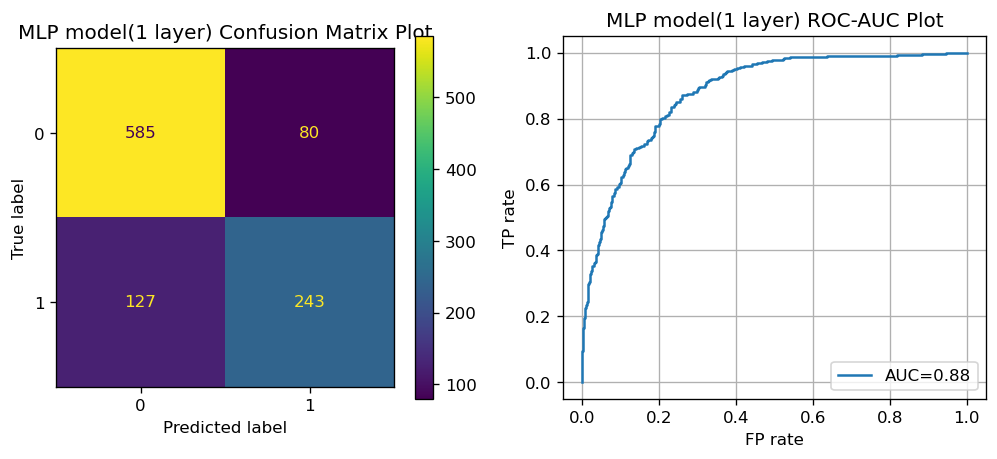

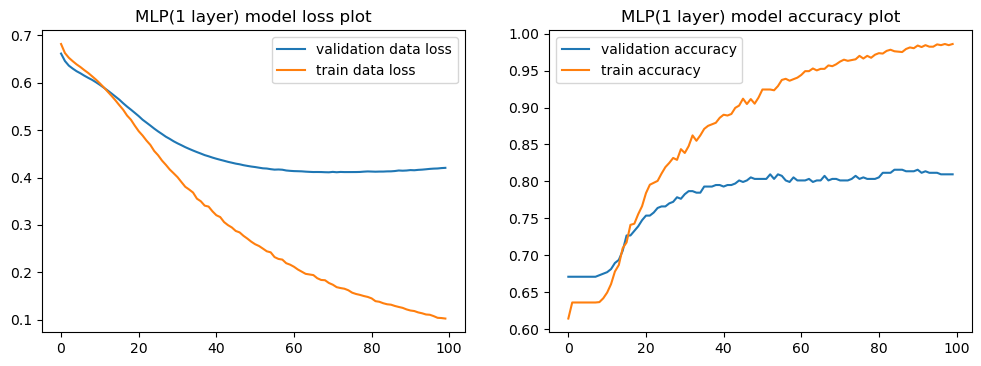

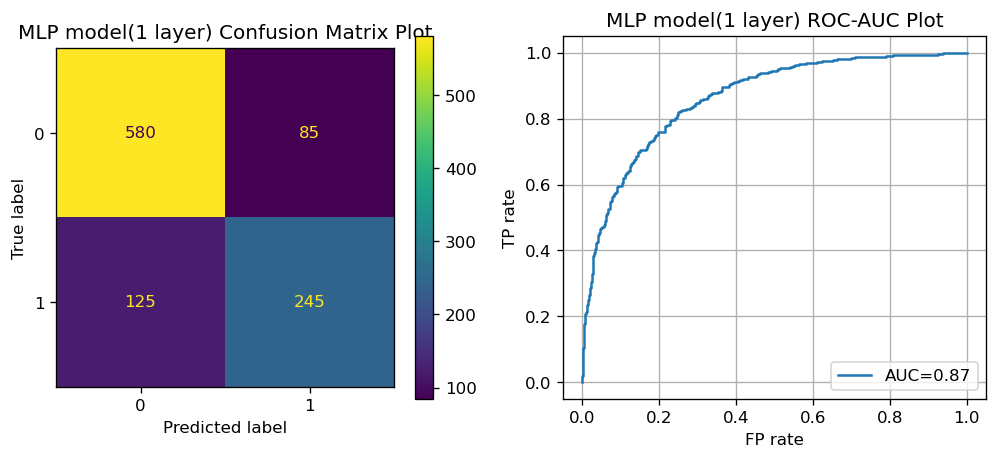

In [232]:
# repeat with best lr
mlp_eva_list_re=[]
for i in range(5):
    vocab,X_train_oh,X_test_oh,X_train_pad,X_train_pad = pad_seq(Tokenizer(split=" "), 
                                                                 X_train_list[i],
                                                                 X_test_list[i], 50,False)
    #Defind
    mlp_model_1 = keras.models.Sequential()
    mlp_model_1.add(keras.layers.Dense(512, input_shape=(len(vocab)+1,), activation='relu'))
    mlp_model_1.add(keras.layers.Dropout(0.3))
    mlp_model_1.add(keras.layers.Dense(1,activation='sigmoid'))

    #complile
    mlp_model_1.compile(tf.keras.optimizers.SGD(lr=lr_list_mlp_1[1]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    #train
    mlp_history_1=mlp_model_1.fit(X_train_oh, y_train_list[i],
                                  batch_size=32,
                                  epochs=100,
                                  validation_split=0.2)

    plot_train('MLP(1 layer) model',mlp_history_1)
    mlp_eva_list= plot_eva(mlp_model_1,'MLP model(1 layer)', X_test_oh, y_test_list[i])

    mlp_eva_list_re.append(mlp_eva_list)

In [262]:
mlp_1_re_df = pd.DataFrame(mlp_eva_list_re,columns=['Accuracy','Precision','Recall','F1','AUC'])

print(mlp_1_re_df)

print(mlp_1_re_df.Accuracy.mean(),mlp_1_re_df.Precision.mean(),mlp_1_re_df.Recall.mean(),mlp_1_re_df.F1.mean(),mlp_1_re_df.AUC.mean())
mlp_1_re_df.loc[len(mlp_1_re_df)]=[mlp_1_re_df.Accuracy.var(),
                                  mlp_1_re_df.Precision.var(),
                                  mlp_1_re_df.Recall.var(),
                                  mlp_1_re_df.F1.var(),
                                  mlp_1_re_df.AUC.var(),]
print(mlp_1_re_df)

   Accuracy  Precision    Recall        F1       AUC
0  0.800966   0.767974  0.635135  0.773745  0.876375
1  0.799034   0.742515  0.670270  0.776138  0.882886
2  0.805797   0.768254  0.654054  0.780721  0.867458
3  0.800000   0.752322  0.656757  0.775486  0.882808
4  0.797101   0.742424  0.662162  0.773358  0.865117
0.8005797101449275 0.7546978036742779 0.6556756756756756 0.7758896365038753 0.8749286730339362
   Accuracy  Precision    Recall        F1       AUC
0  0.800966   0.767974  0.635135  0.773745  0.876375
1  0.799034   0.742515  0.670270  0.776138  0.882886
2  0.805797   0.768254  0.654054  0.780721  0.867458
3  0.800000   0.752322  0.656757  0.775486  0.882808
4  0.797101   0.742424  0.662162  0.773358  0.865117
5  0.000011   0.000166  0.000170  0.000009  0.000070


In [184]:
mlp_model_1._name = 'MLP_1_layer_model'
mlp_model_1.summary()

Model: "MLP_1_layer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               3043840   
_________________________________________________________________
dropout_64 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513       
Total params: 3,044,353
Trainable params: 3,044,353
Non-trainable params: 0
_________________________________________________________________


#### MLP-4

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 0.6898 - accuracy: 0.5655 - val_loss: 0.6837 - val_accuracy: 0.6542
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6817 - accuracy: 0.6354 - val_loss: 0.6742 - val_accuracy: 0.6542
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6748 - accuracy: 0.6375 - val_loss: 0.6666 - val_accuracy: 0.6542
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6679 - accuracy: 0.6380 - val_loss: 0.6608 - val_accuracy: 0.6542
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6644 - accuracy: 0.6375 - val_loss: 0.6563 - val_accuracy: 0.6542
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6613 - accuracy: 0.6375 - val_loss: 0.6532 - val_accuracy: 0.6542
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 0.6581 - accuracy: 0.6375 - val_loss: 0.6506 - val_accuracy: 0.6542
Epoch 

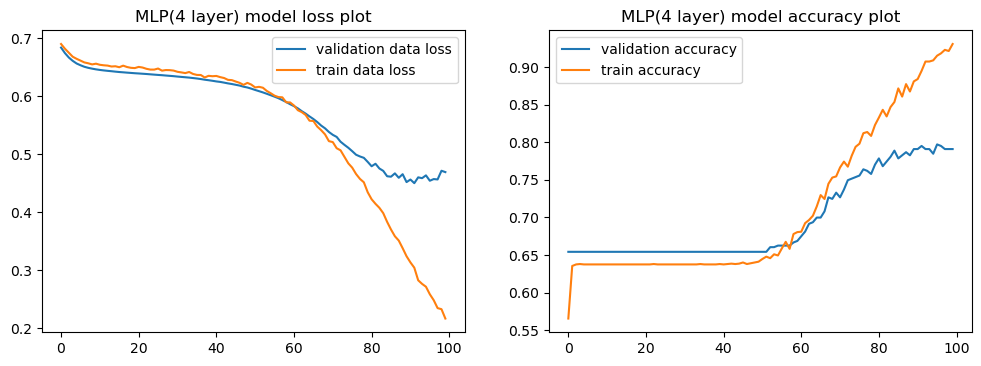

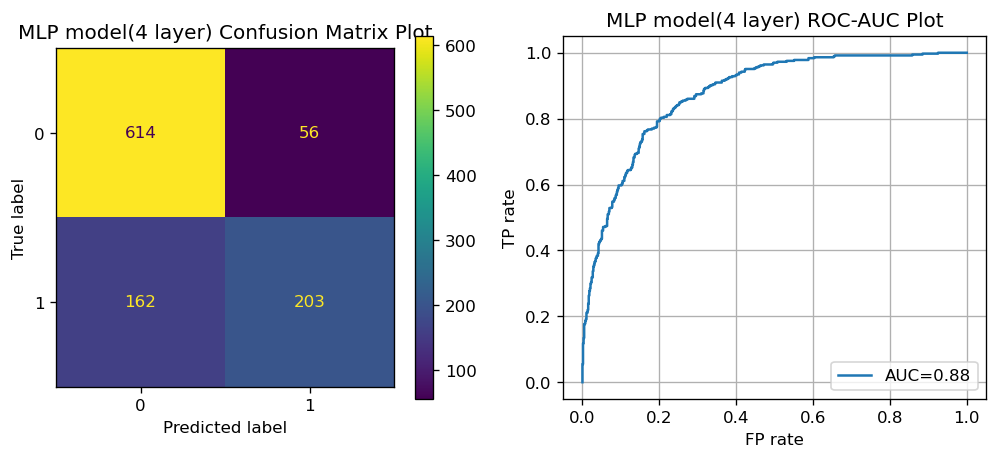

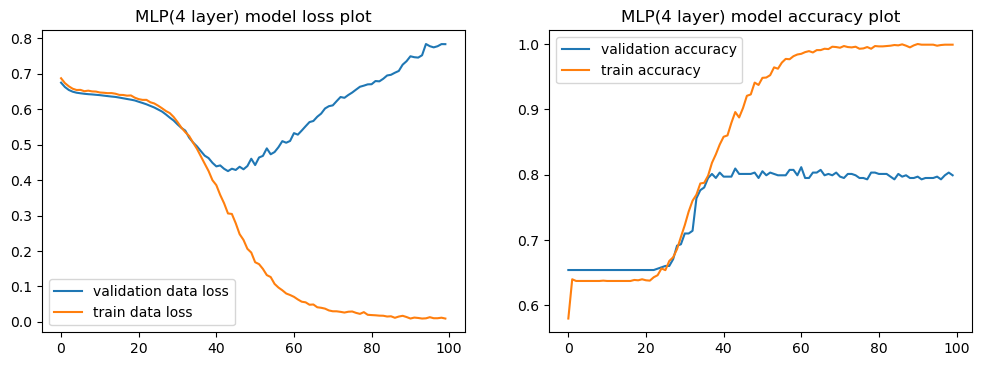

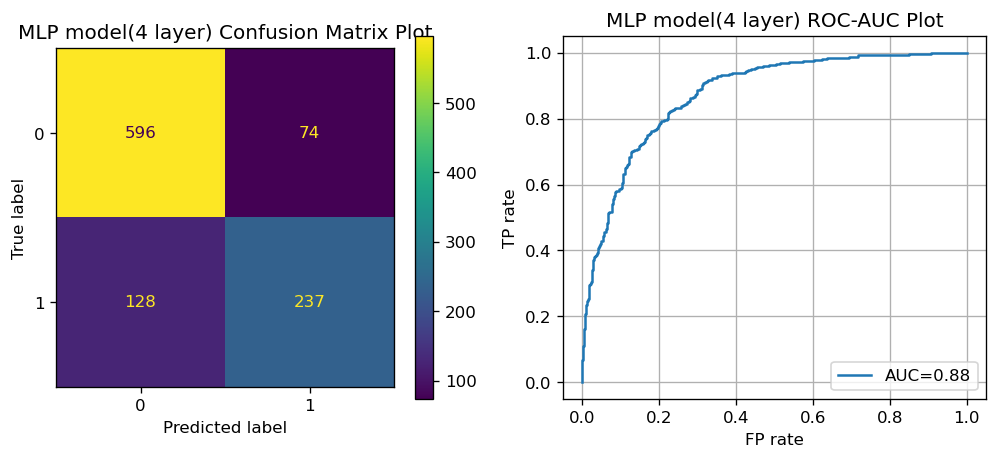

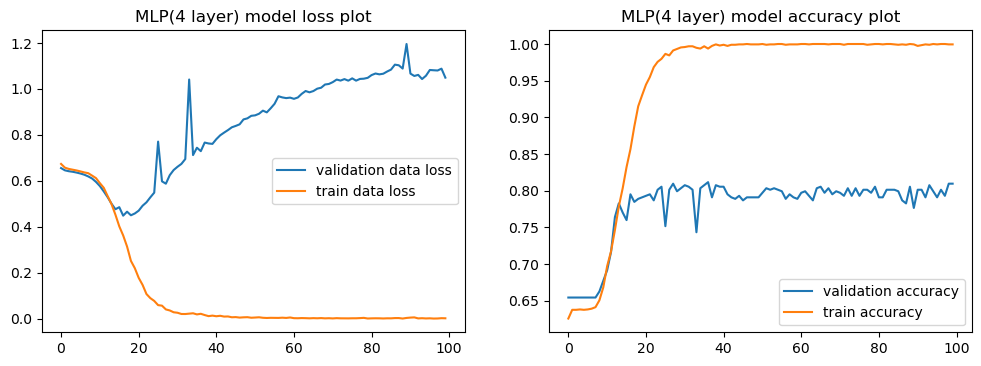

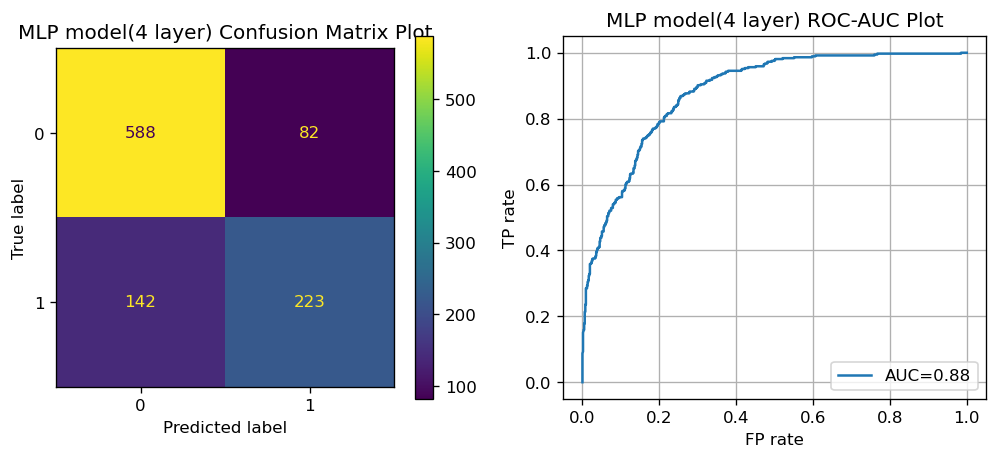

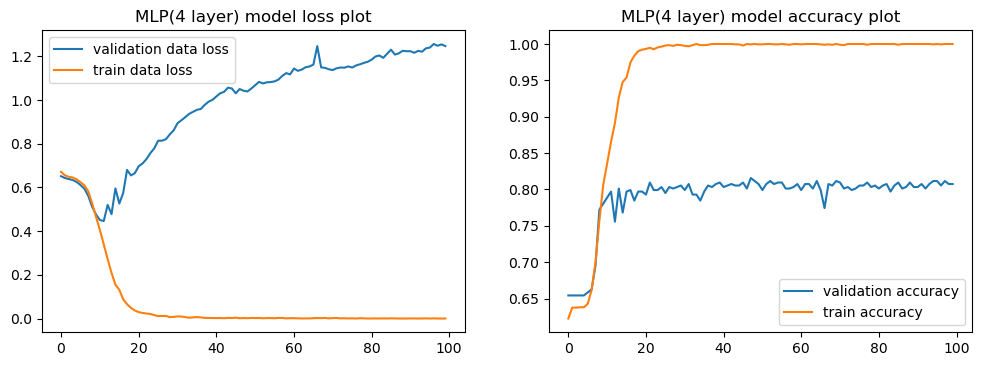

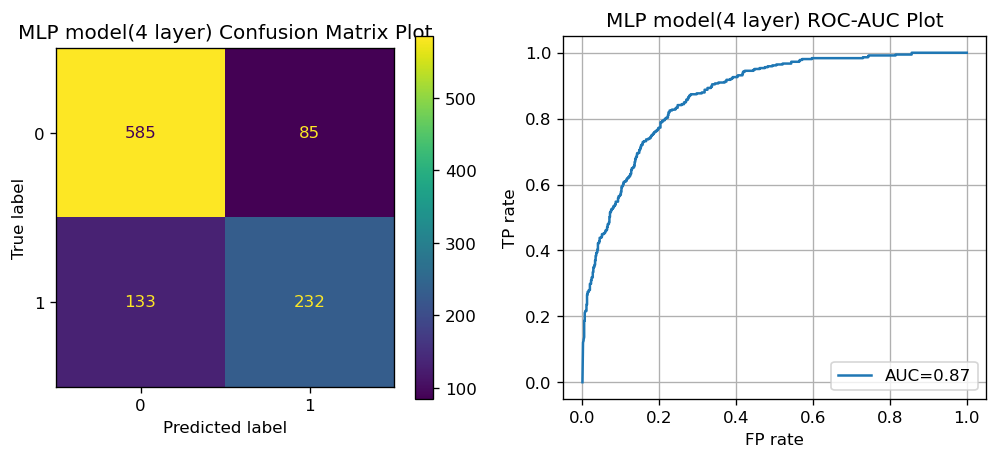

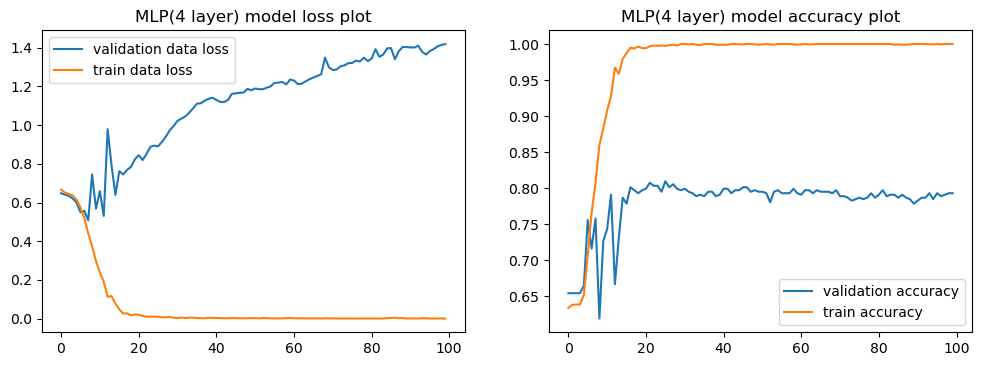

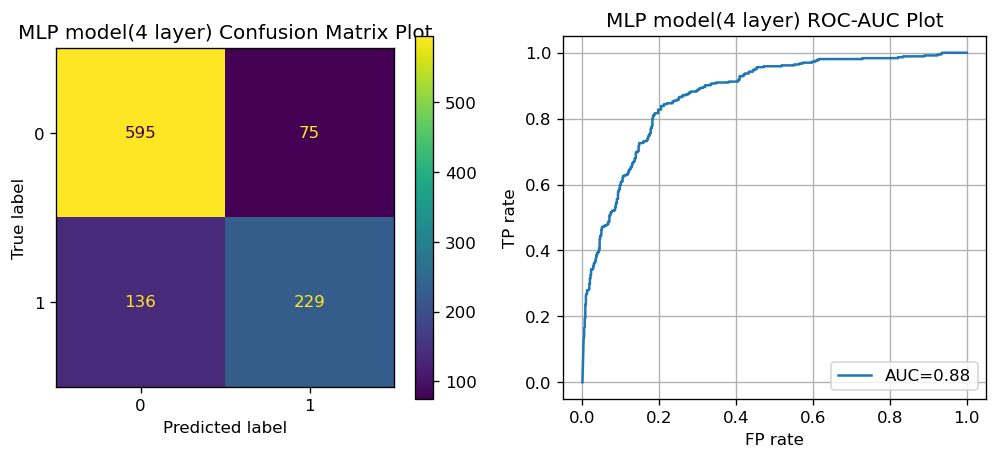

In [215]:
# parameter tune
lr_list_mlp_4 = [0.01,0.02,0.05,0.075,0.1]
mlp_4_eva_list_ht=[]

for i in range(len(lr_list_mlp_4)):
    # define
    mlp_model_4 = keras.models.Sequential()
    mlp_model_4.add(keras.layers.Dense(512, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(256, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(128, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(64, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(1,activation='sigmoid'))
    #complile
    mlp_model_4.compile(tf.keras.optimizers.SGD(lr=lr_list_mlp_4[i]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    #train
    mlp_history_4=mlp_model_4.fit(X_train_oh_ht, np.array(y_train_ht),
              batch_size=64,
              epochs=100,
              validation_split=0.2)

    # plot train
    plot_train('MLP(4 layer) model',mlp_history_4)
    mlp_eva_list_4= plot_eva(mlp_model_4,'MLP model(4 layer)', X_test_oh_ht, y_test_ht)
    mlp_4_eva_list_ht.append(mlp_eva_list_4)

In [236]:
# find best lr
print(pd.DataFrame(mlp_4_eva_list_ht,columns=['Accuracy','Precision','Recall','F1','AUC']))
print('best lr:',lr_list_mlp_4[0])

   Accuracy  Precision    Recall        F1       AUC
0  0.789372   0.783784  0.556164  0.749940  0.876972
1  0.804831   0.762058  0.649315  0.778138  0.877089
2  0.783575   0.731148  0.610959  0.752836  0.881501
3  0.789372   0.731861  0.635616  0.761646  0.872928
4  0.796135   0.753289  0.627397  0.766999  0.875056
best lr: 0.01


Epoch 1/100
61/61 [==============================] - 1s 14ms/step - loss: 0.6864 - accuracy: 0.5831 - val_loss: 0.6732 - val_accuracy: 0.6480
Epoch 2/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6708 - accuracy: 0.6406 - val_loss: 0.6616 - val_accuracy: 0.6480
Epoch 3/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6608 - accuracy: 0.6422 - val_loss: 0.6542 - val_accuracy: 0.6480
Epoch 4/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6546 - accuracy: 0.6416 - val_loss: 0.6500 - val_accuracy: 0.6480
Epoch 5/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6503 - accuracy: 0.6416 - val_loss: 0.6473 - val_accuracy: 0.6480
Epoch 6/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6498 - accuracy: 0.6422 - val_loss: 0.6456 - val_accuracy: 0.6480
Epoch 7/100
61/61 [==============================] - 1s 13ms/step - loss: 0.6496 - accuracy: 0.6416 - val_loss: 0.6439 - val_accuracy: 0.6480
Epoch 

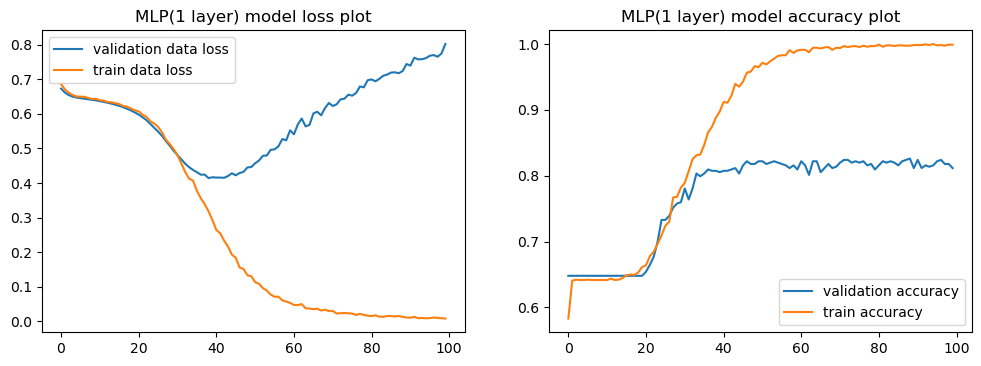

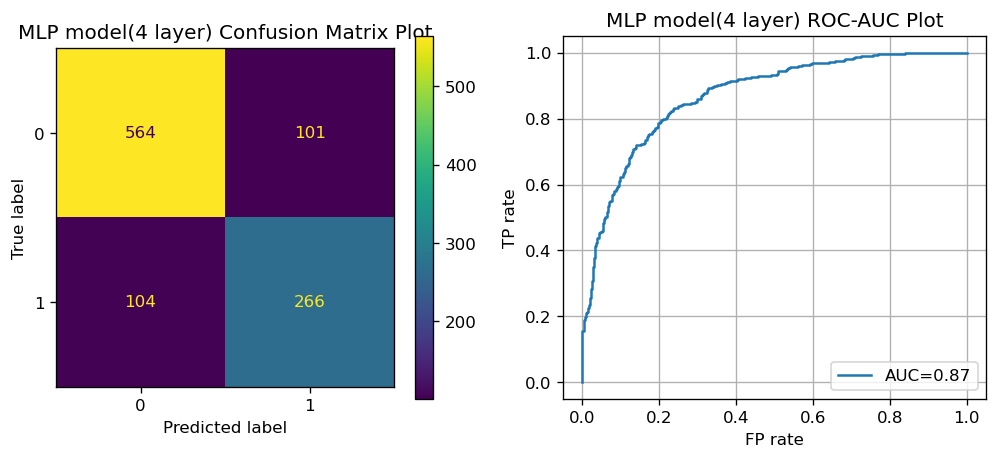

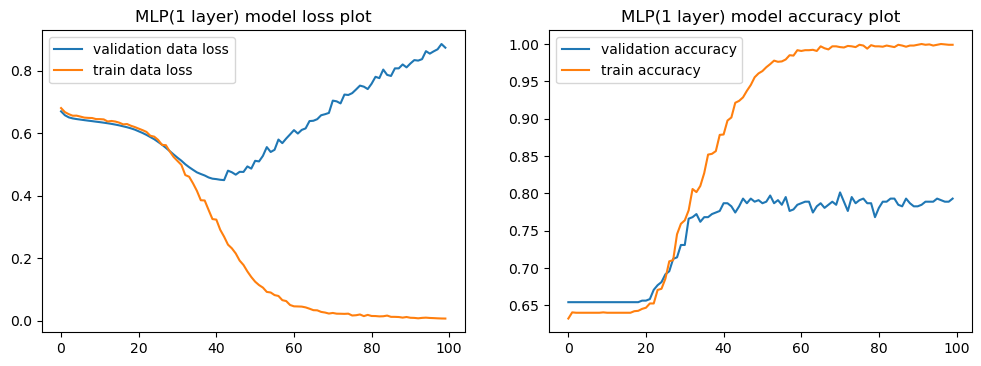

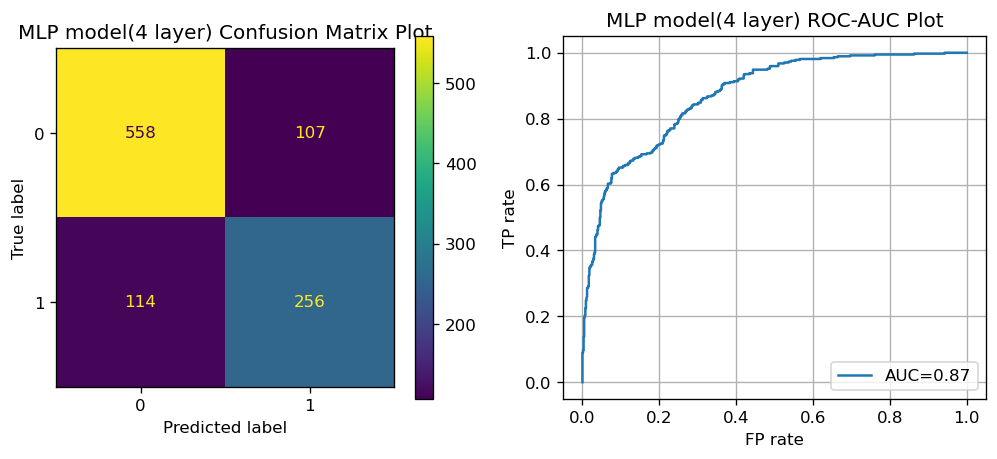

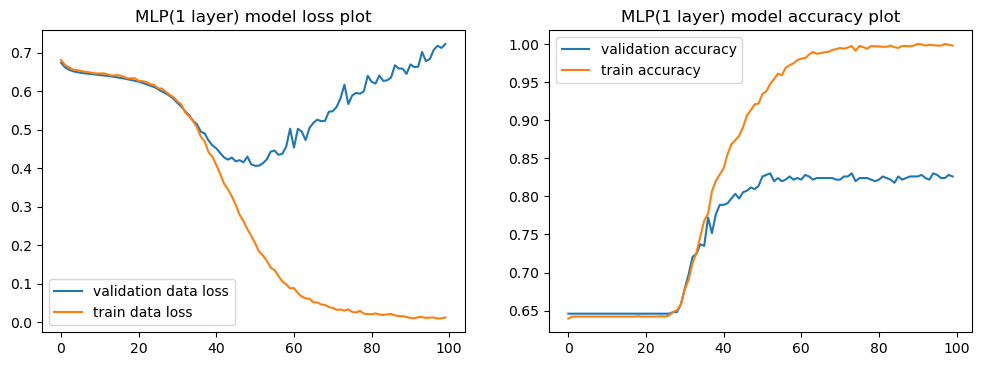

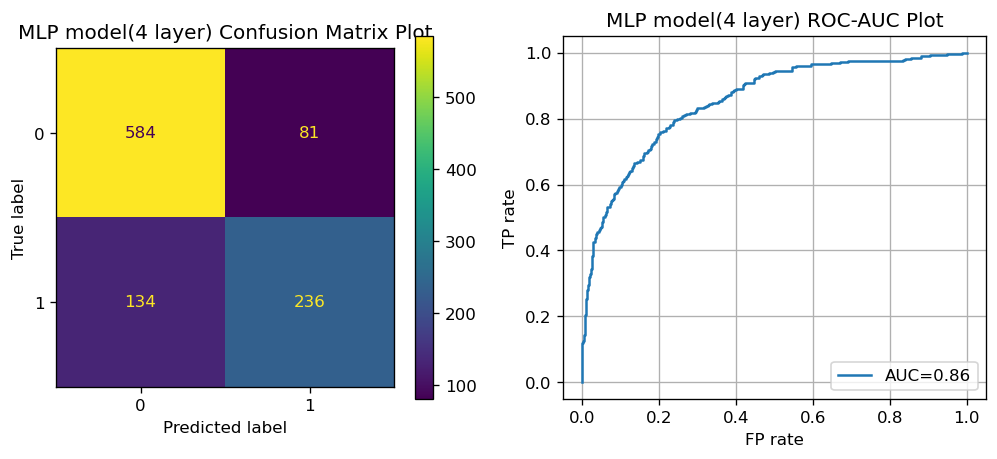

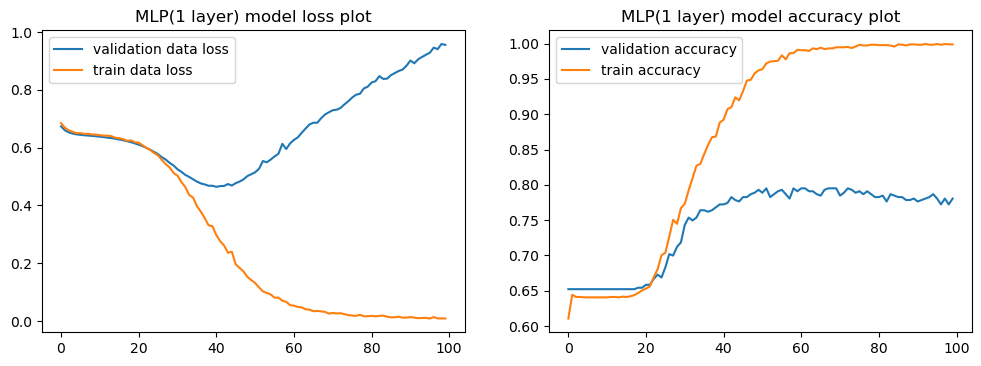

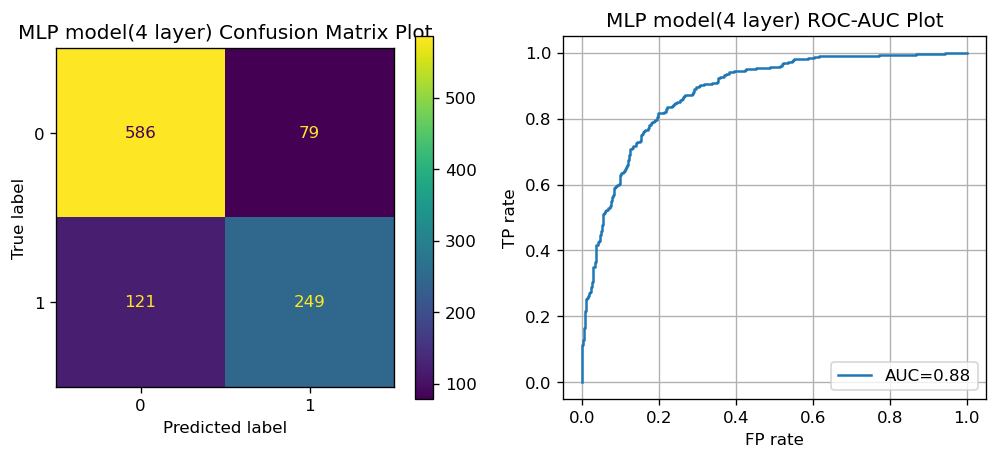

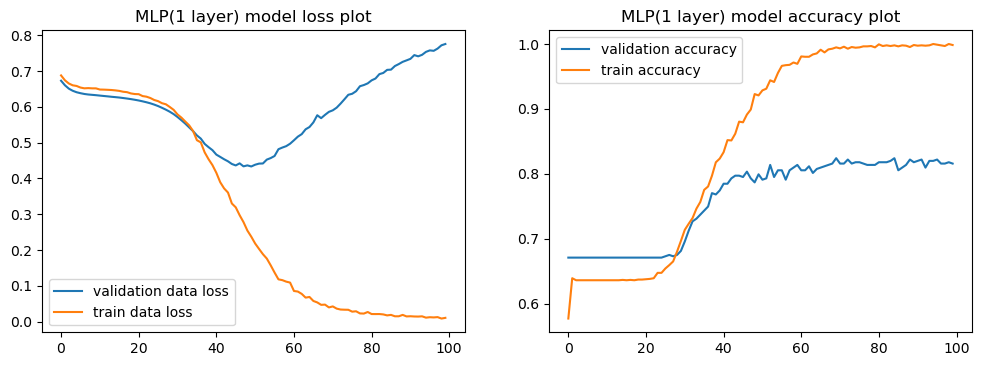

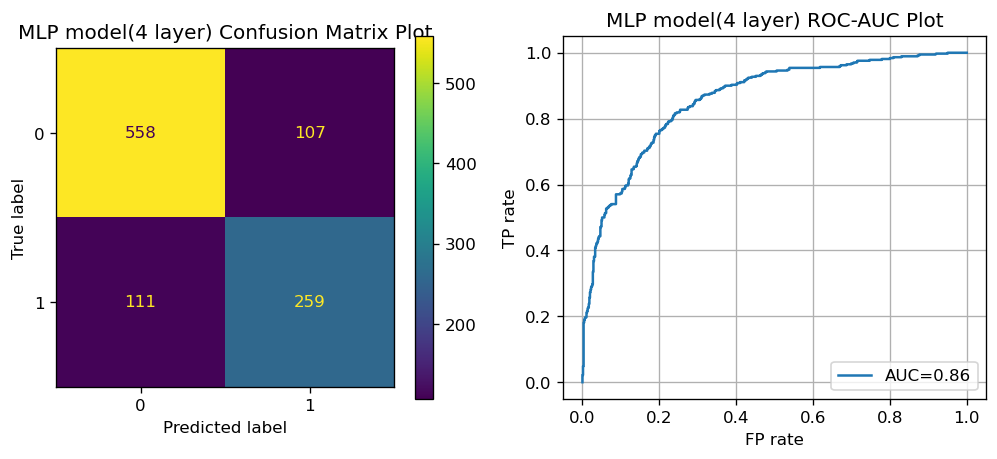

In [237]:
# repeat with best lr
mlp_4_eva_list_re=[]
for i in range(5):
    vocab,X_train_oh,X_test_oh,X_train_pad,X_train_pad = pad_seq(Tokenizer(split=" "), 
                                                                 X_train_list[i],
                                                                 X_test_list[i], 50,False)
    # define
    mlp_model_4 = keras.models.Sequential()
    mlp_model_4.add(keras.layers.Dense(512, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(256, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(128, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(64, activation='relu'))
    mlp_model_4.add(keras.layers.Dropout(0.35))
    mlp_model_4.add(keras.layers.Dense(1,activation='sigmoid'))
    #complile
    mlp_model_4.compile(tf.keras.optimizers.SGD(lr=lr_list_mlp_4[0]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    #train
    mlp_history_4=mlp_model_4.fit(X_train_oh, y_train_list[i],
                                  batch_size=32,
                                  epochs=100,
                                  validation_split=0.2)

    plot_train('MLP(1 layer) model',mlp_history_4)
    mlp_eva_list_4= plot_eva(mlp_model_4,'MLP model(4 layer)', X_test_oh, y_test_list[i])

    mlp_4_eva_list_re.append(mlp_eva_list_4)

In [263]:
mlp_4_re_df = pd.DataFrame(mlp_4_eva_list_re,columns=['Accuracy','Precision','Recall','F1','AUC'])

print(mlp_4_re_df.Accuracy.mean(),mlp_4_re_df.Precision.mean(),mlp_4_re_df.Recall.mean(),mlp_4_re_df.F1.mean(),mlp_4_re_df.AUC.mean())

mlp_4_re_df.loc[len(mlp_4_re_df)]=[mlp_4_re_df.Accuracy.var(),
                                  mlp_4_re_df.Precision.var(),
                                  mlp_4_re_df.Recall.var(),
                                  mlp_4_re_df.F1.var(),
                                  mlp_4_re_df.AUC.var(),]
print(mlp_4_re_df.T)

0.7953623188405797 0.7282611820124375 0.6843243243243243 0.7740927239947398 0.8684852672221093
                  0         1         2         3         4         5
Accuracy   0.801932  0.786473  0.792271  0.806763  0.789372  0.000074
Precision  0.724796  0.705234  0.744479  0.759146  0.707650  0.000546
Recall     0.718919  0.691892  0.637838  0.672973  0.700000  0.000947
F1         0.784028  0.766602  0.765793  0.783847  0.770193  0.000084
AUC        0.871185  0.872906  0.855838  0.883162  0.859336  0.000121


In [187]:
mlp_model_4._name = 'MLP_4_layer_model'
mlp_model_4.summary()

Model: "MLP_4_layer_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 512)               3043840   
_________________________________________________________________
dropout_65 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)          

#### cnn

Epoch 1/35
16/16 [==============================] - 1s 65ms/step - loss: 0.6615 - accuracy: 0.6173 - val_loss: 0.6386 - val_accuracy: 0.6542
Epoch 2/35
16/16 [==============================] - 1s 58ms/step - loss: 0.6414 - accuracy: 0.6375 - val_loss: 0.6295 - val_accuracy: 0.6542
Epoch 3/35
16/16 [==============================] - 1s 60ms/step - loss: 0.6292 - accuracy: 0.6390 - val_loss: 0.6170 - val_accuracy: 0.6542
Epoch 4/35
16/16 [==============================] - 1s 57ms/step - loss: 0.6147 - accuracy: 0.6427 - val_loss: 0.6057 - val_accuracy: 0.6563
Epoch 5/35
16/16 [==============================] - 1s 57ms/step - loss: 0.5959 - accuracy: 0.6789 - val_loss: 0.5925 - val_accuracy: 0.6708
Epoch 6/35
16/16 [==============================] - 1s 58ms/step - loss: 0.5689 - accuracy: 0.7193 - val_loss: 0.5814 - val_accuracy: 0.7267
Epoch 7/35
16/16 [==============================] - 1s 57ms/step - loss: 0.5472 - accuracy: 0.7442 - val_loss: 0.5718 - val_accuracy: 0.7329
Epoch 8/35
16

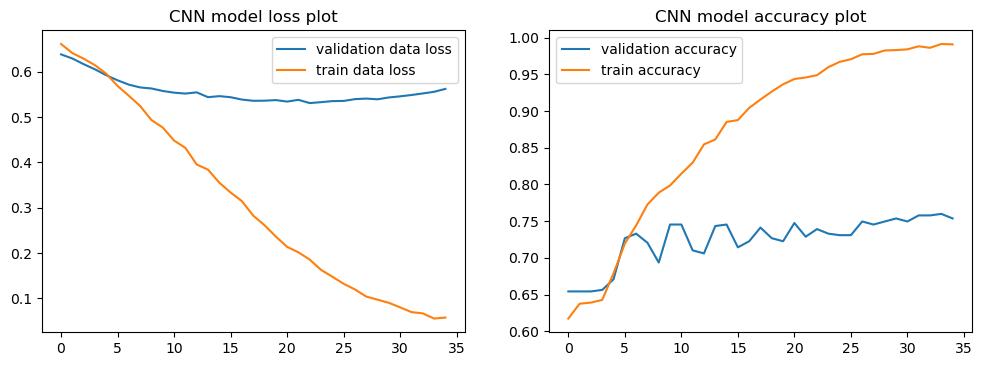

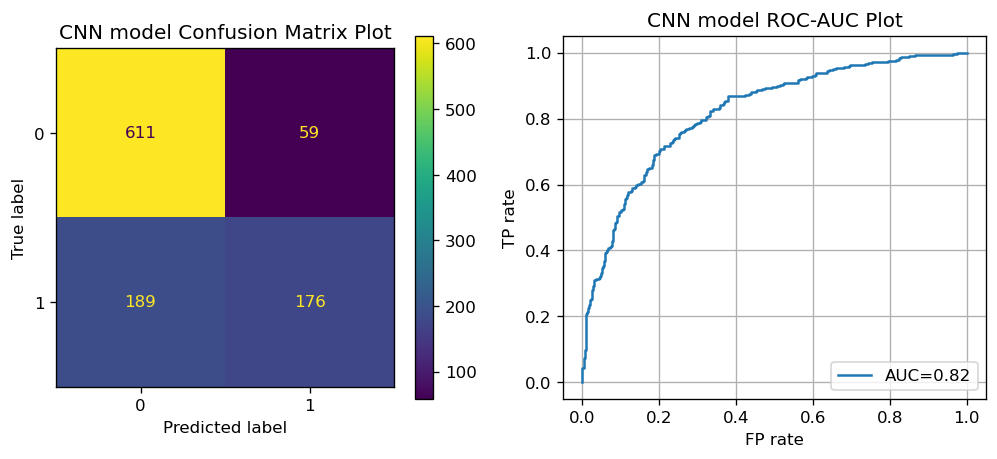

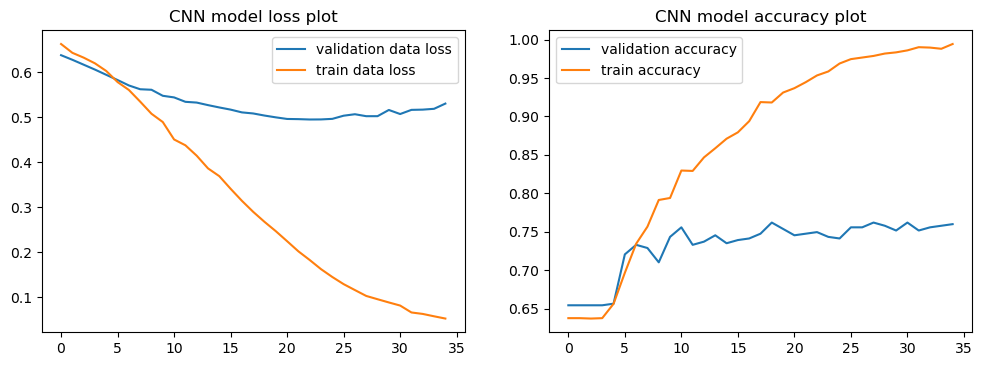

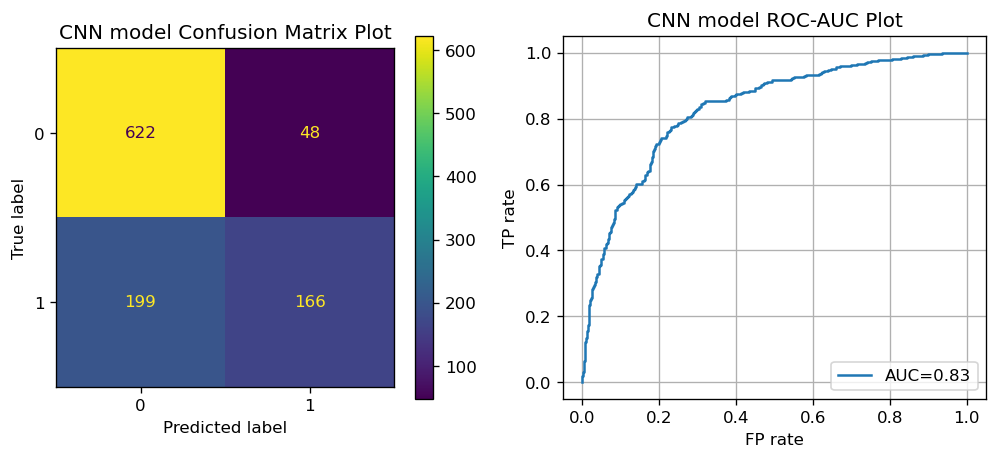

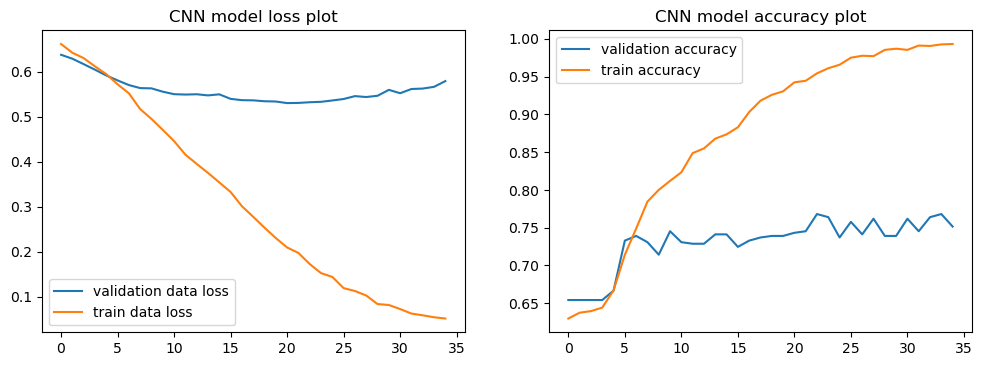

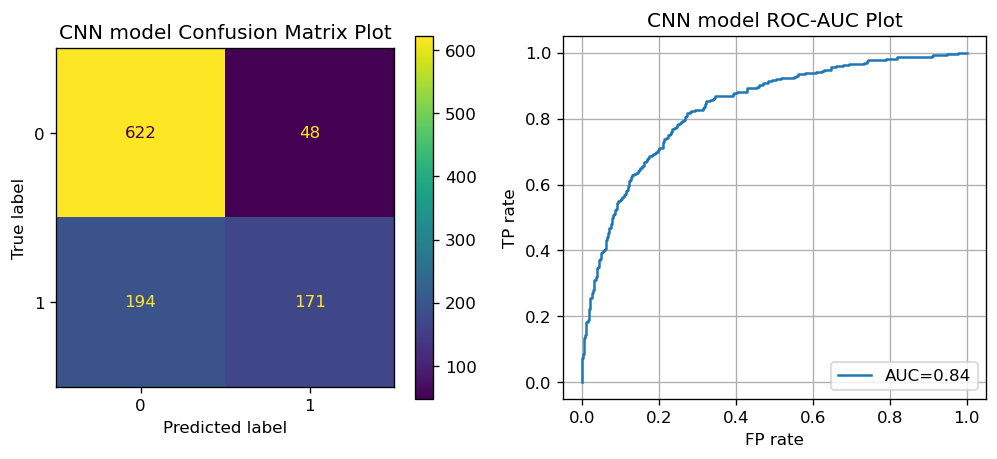

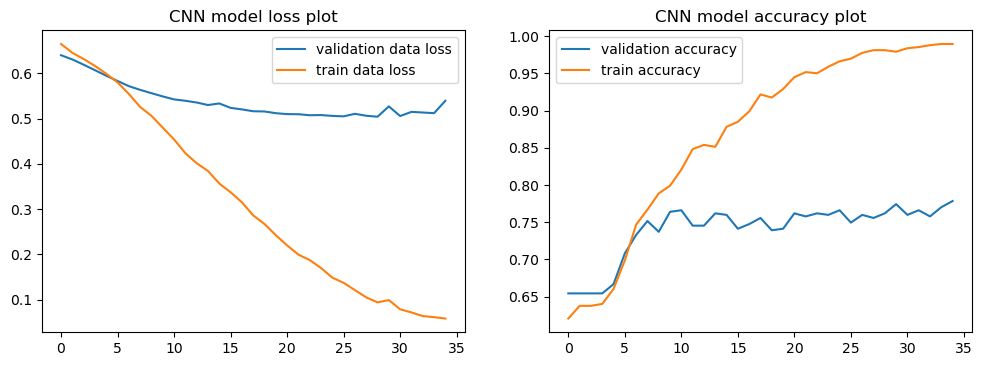

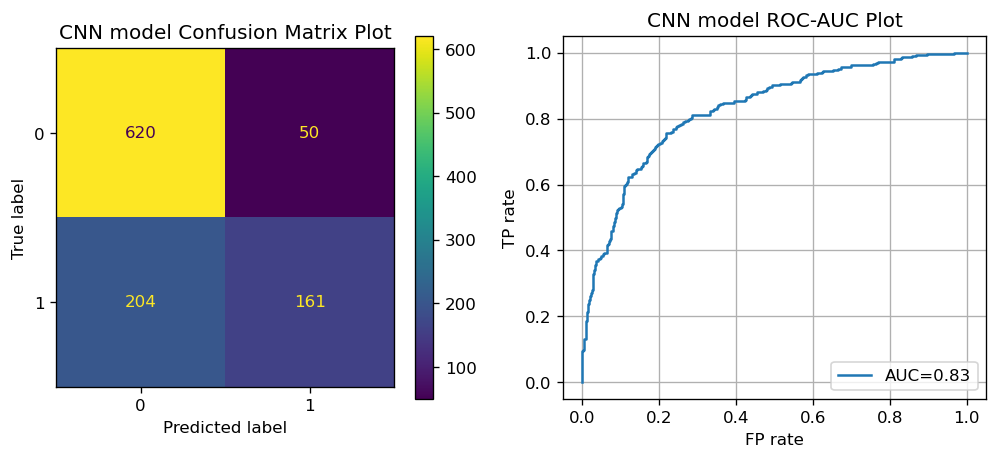

In [219]:
from tensorflow.keras.layers import Embedding, Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import concatenate
# parameter tune
lr_list_cnn = [0.0001,0.0005,0.001,0.005]
cnn_eva_list_ht=[]

for i in range(len(lr_list_cnn)):
    #build
    cnn_in = keras.layers.Input(shape=(50,))
    embedder = Embedding(len(vocab_ht) + 1, 300, input_length=50, trainable=False)
    emb= embedder(cnn_in)

    cnn1 = Convolution1D(100, 5, padding='valid', strides = 1, activation='relu')(emb)
    cnn1 = MaxPool1D(pool_size=46)(cnn1)

    cnn2 = Convolution1D(100, 4, padding='valid', strides = 1, activation='relu')(emb)
    cnn2 = MaxPool1D(pool_size=47)(cnn2)

    cnn = concatenate([cnn1,cnn2], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.5)(flat)

    cnn_dense = keras.layers.Dense(300, activation='relu')(drop)
    cnn_out = keras.layers.Dense(1, activation='sigmoid')(cnn_dense)## compile
    cnn_model = keras.Model(cnn_in, cnn_out)
    #complie
    cnn_model.compile(tf.keras.optimizers.Adam(lr=0.0003),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    #train
    cnn_history =cnn_model.fit(X_train_pad_ht,np.array(y_train_ht),
              batch_size=128,
              epochs=35,
              validation_split=0.2)

    # plot train
    plot_train('CNN model',cnn_history)
    cnn_eva_list= plot_eva(cnn_model,'CNN model', X_test_pad_ht, y_test_ht)
    cnn_eva_list_ht.append(cnn_eva_list)
    

In [240]:
# find best lr
print(pd.DataFrame(cnn_eva_list_ht,columns=['Accuracy','Precision','Recall','F1','AUC']))
print('best lr:',lr_list_cnn[2])

   Accuracy  Precision    Recall        F1       AUC
0  0.760386   0.748936  0.482192  0.708980  0.821247
1  0.761353   0.775701  0.454795  0.703871  0.832537
2  0.766184   0.780822  0.468493  0.711382  0.837624
3  0.754589   0.763033  0.441096  0.694507  0.830468
best lr: 0.001


Epoch 1/35
16/16 [==============================] - 1s 52ms/step - loss: 0.6463 - accuracy: 0.6349 - val_loss: 0.6106 - val_accuracy: 0.6480
Epoch 2/35
16/16 [==============================] - 1s 44ms/step - loss: 0.5994 - accuracy: 0.6696 - val_loss: 0.5822 - val_accuracy: 0.6770
Epoch 3/35
16/16 [==============================] - 1s 46ms/step - loss: 0.5455 - accuracy: 0.7312 - val_loss: 0.5362 - val_accuracy: 0.7495
Epoch 4/35
16/16 [==============================] - 1s 45ms/step - loss: 0.4885 - accuracy: 0.7732 - val_loss: 0.5145 - val_accuracy: 0.7598
Epoch 5/35
16/16 [==============================] - 1s 44ms/step - loss: 0.4159 - accuracy: 0.8322 - val_loss: 0.5027 - val_accuracy: 0.7640
Epoch 6/35
16/16 [==============================] - 1s 45ms/step - loss: 0.3711 - accuracy: 0.8566 - val_loss: 0.5005 - val_accuracy: 0.7557
Epoch 7/35
16/16 [==============================] - 1s 46ms/step - loss: 0.3074 - accuracy: 0.8902 - val_loss: 0.4978 - val_accuracy: 0.7619
Epoch 8/35
16

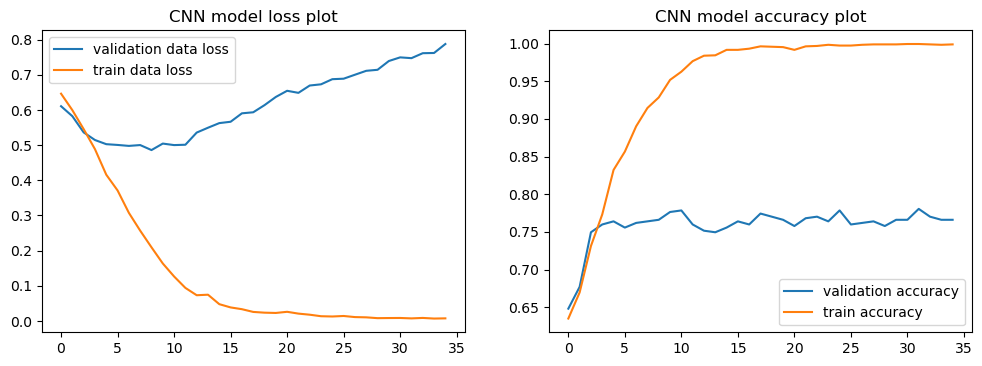

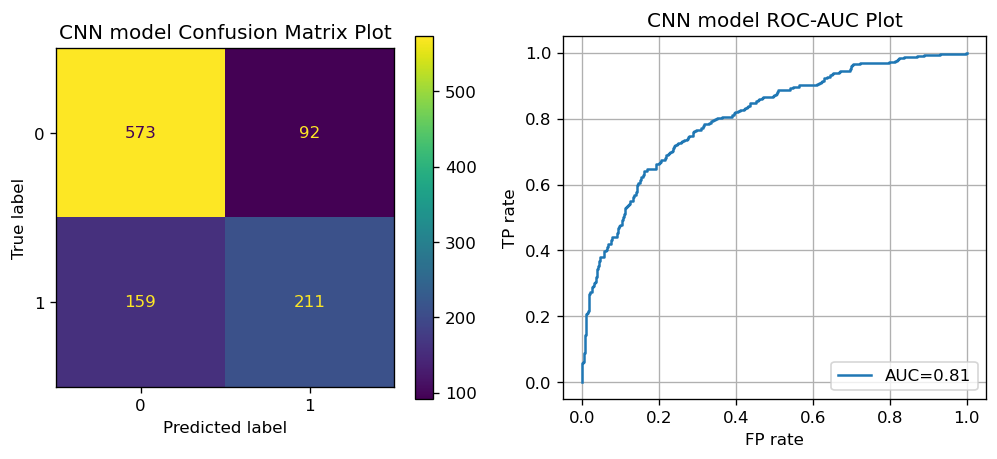

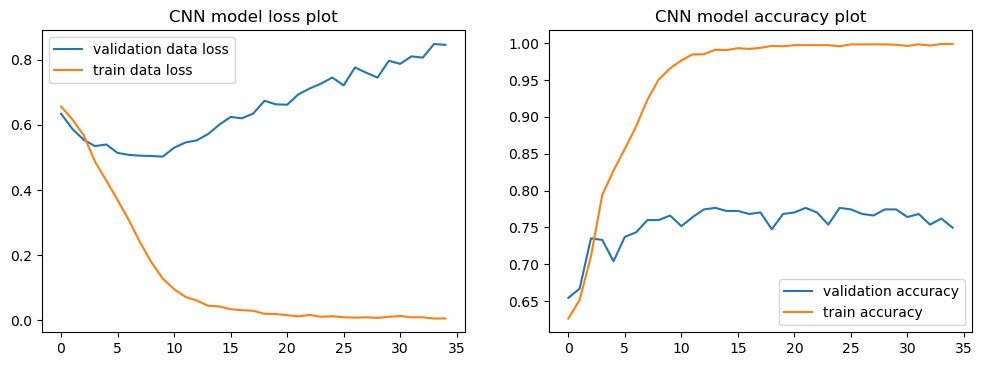

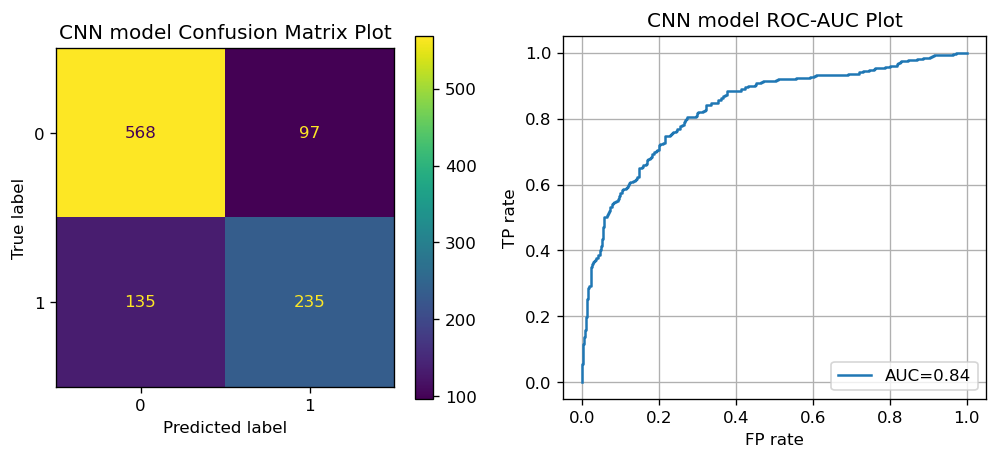

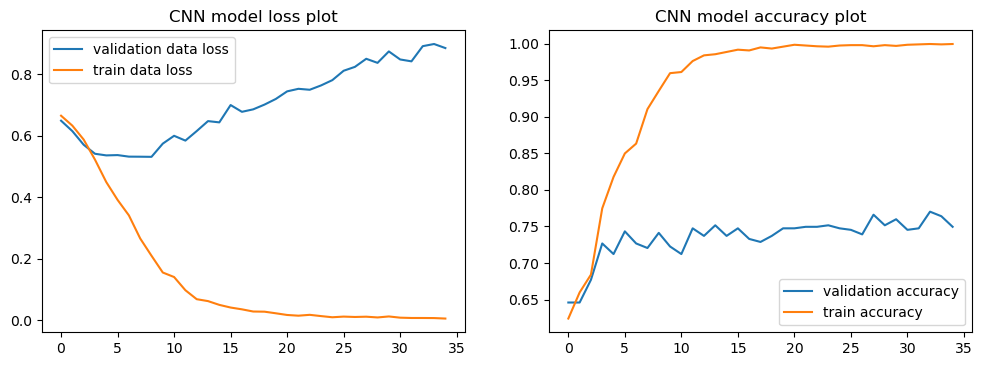

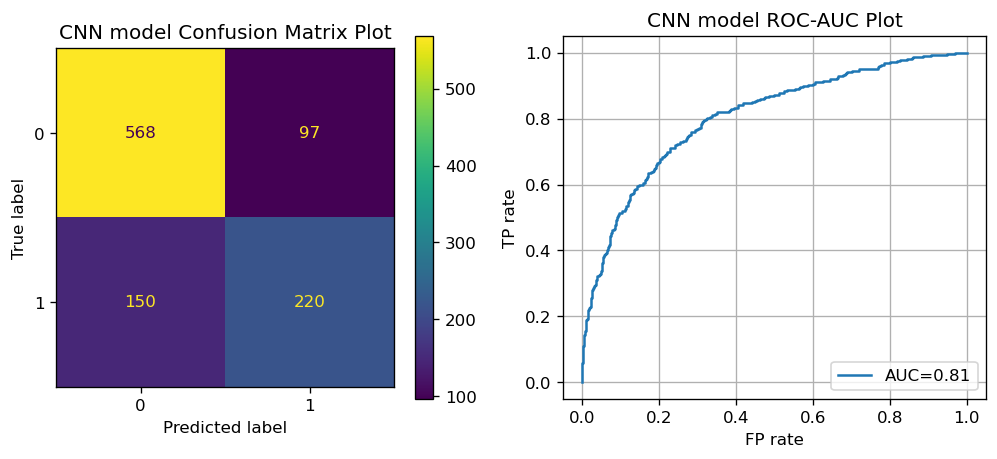

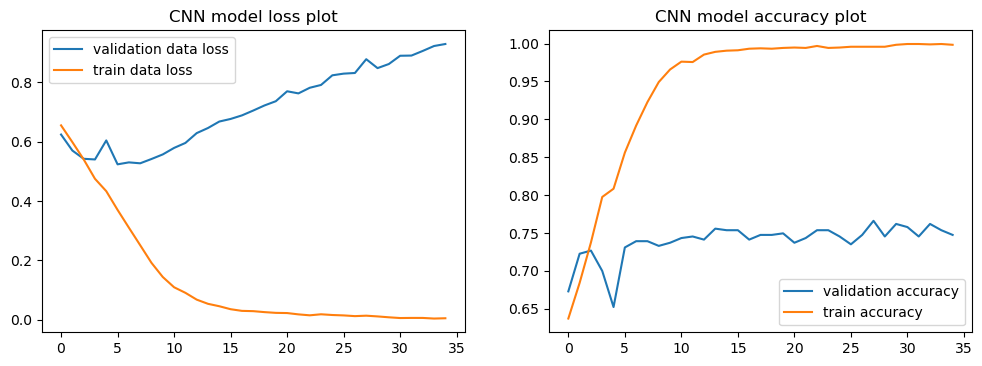

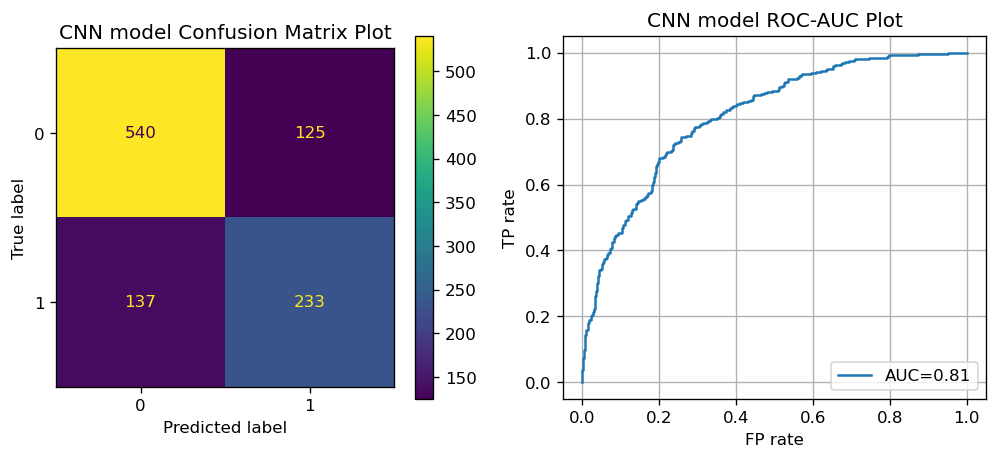

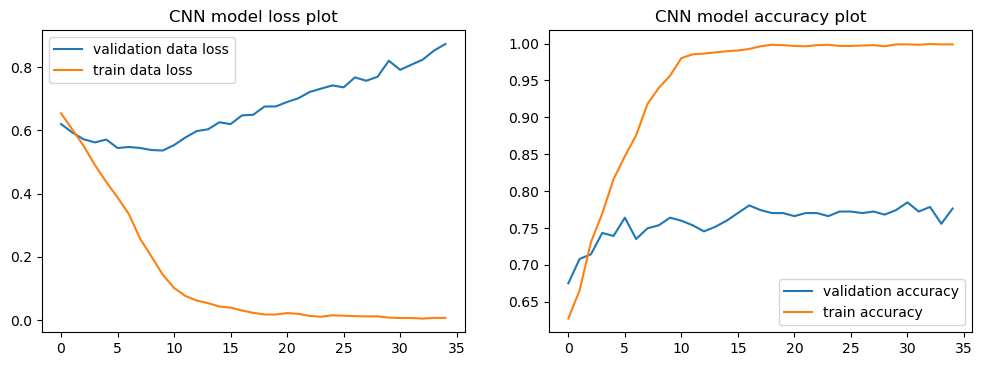

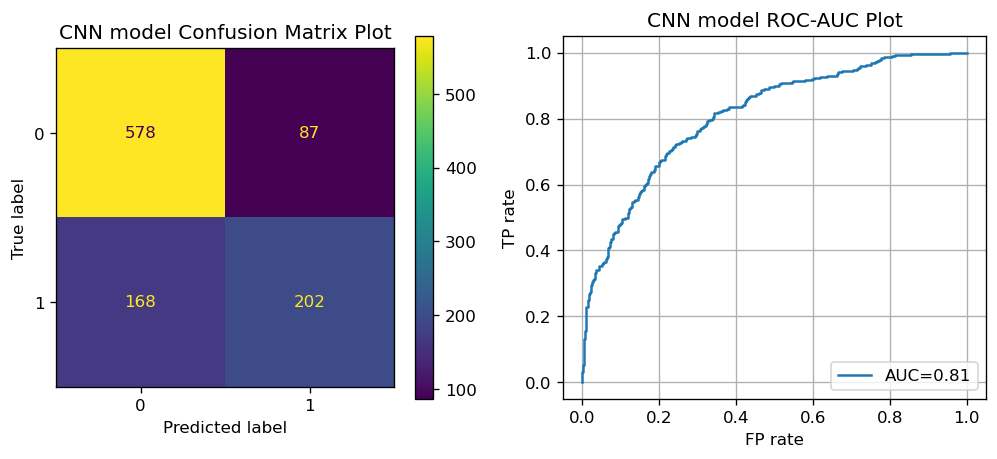

In [242]:
# repeat with best lr
cnn_eva_list_re=[]
for i in range(5):
    vocab,X_train_oh,X_test_oh,X_train_pad,X_test_pad = pad_seq(Tokenizer(split=" "), 
                                                                 X_train_list[i],
                                                                 X_test_list[i], 50,False)
    #build
    cnn_in = keras.layers.Input(shape=(50,))
    embedder = Embedding(len(vocab) + 1, 300, input_length=50, trainable=False)
    emb= embedder(cnn_in)

    cnn1 = Convolution1D(100, 5, padding='valid', strides = 1, activation='relu')(emb)
    cnn1 = MaxPool1D(pool_size=46)(cnn1)

    cnn2 = Convolution1D(100, 4, padding='valid', strides = 1, activation='relu')(emb)
    cnn2 = MaxPool1D(pool_size=47)(cnn2)

    cnn = concatenate([cnn1,cnn2], axis=-1)
    flat = Flatten()(cnn)
    drop = Dropout(0.5)(flat)

    cnn_dense = keras.layers.Dense(300, activation='relu')(drop)
    cnn_out = keras.layers.Dense(1, activation='sigmoid')(cnn_dense)## compile
    cnn_model = keras.Model(cnn_in, cnn_out)
    
    #complie
    cnn_model.compile(tf.keras.optimizers.Adam(lr=lr_list_cnn[2]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    
    #train
    cnn_history=cnn_model.fit(X_train_pad, y_train_list[i],
                                  batch_size=128,
                                  epochs=35,
                                  validation_split=0.2)

    plot_train('CNN model',cnn_history)
    cnn_eva_list= plot_eva(cnn_model,'CNN model', X_test_pad, y_test_list[i])

    cnn_eva_list_re.append(cnn_eva_list)

In [264]:
cnn_re_df = pd.DataFrame(cnn_eva_list_re,columns=['Accuracy','Precision','Recall','F1','AUC'])

print(cnn_re_df.Accuracy.mean(),cnn_re_df.Precision.mean(),cnn_re_df.Recall.mean(),cnn_re_df.F1.mean(),cnn_re_df.AUC.mean())

cnn_re_df.loc[len(cnn_re_df)]=[cnn_re_df.Accuracy.var(),
                                  cnn_re_df.Precision.var(),
                                  cnn_re_df.Recall.var(),
                                  cnn_re_df.F1.var(),
                                  cnn_re_df.AUC.var(),]
print(cnn_re_df.T)


0.7590338164251207 0.689601439591249 0.595135135135135 0.7286372010762665 0.8142800243852875
                  0         1         2         3         4         5
Accuracy   0.757488  0.775845  0.761353  0.746860  0.753623  0.000117
Precision  0.696370  0.707831  0.694006  0.650838  0.698962  0.000497
Recall     0.570270  0.635135  0.594595  0.629730  0.545946  0.001459
F1         0.723686  0.749963  0.730934  0.722439  0.716164  0.000170
AUC        0.807169  0.835038  0.806588  0.811022  0.811583  0.000140


In [190]:
cnn_model._name='CNN model'
cnn_model.summary()

Model: "CNN model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 50, 300)      1783200     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 46, 100)      150100      embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 47, 100)      120100      embedding_11[0][0]               
__________________________________________________________________________________________

#### lstm

Epoch 1/15
16/16 [==============================] - 11s 718ms/step - loss: 0.6912 - accuracy: 0.5728 - val_loss: 0.6889 - val_accuracy: 0.6501
Epoch 2/15
16/16 [==============================] - 11s 675ms/step - loss: 0.6873 - accuracy: 0.6349 - val_loss: 0.6843 - val_accuracy: 0.6542
Epoch 3/15
16/16 [==============================] - 11s 680ms/step - loss: 0.6829 - accuracy: 0.6396 - val_loss: 0.6794 - val_accuracy: 0.6542
Epoch 4/15
16/16 [==============================] - 11s 682ms/step - loss: 0.6784 - accuracy: 0.6380 - val_loss: 0.6733 - val_accuracy: 0.6542
Epoch 5/15
16/16 [==============================] - 11s 713ms/step - loss: 0.6722 - accuracy: 0.6375 - val_loss: 0.6651 - val_accuracy: 0.6542
Epoch 6/15
16/16 [==============================] - 12s 736ms/step - loss: 0.6641 - accuracy: 0.6375 - val_loss: 0.6550 - val_accuracy: 0.6542
Epoch 7/15
16/16 [==============================] - 12s 726ms/step - loss: 0.6543 - accuracy: 0.6375 - val_loss: 0.6428 - val_accuracy: 0.6542

D:\python\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy in test: 0.647
Precision in test: 0.000
Recall in test: 0.000
F1-Score in test: 0.393
auc in test: 0.767
Epoch 1/15
16/16 [==============================] - 13s 785ms/step - loss: 0.6842 - accuracy: 0.6287 - val_loss: 0.6691 - val_accuracy: 0.6542
Epoch 2/15
16/16 [==============================] - 12s 731ms/step - loss: 0.6580 - accuracy: 0.6375 - val_loss: 0.6269 - val_accuracy: 0.6542
Epoch 3/15
16/16 [==============================] - 12s 733ms/step - loss: 0.6291 - accuracy: 0.6375 - val_loss: 0.6162 - val_accuracy: 0.6542
Epoch 4/15
16/16 [==============================] - 11s 709ms/step - loss: 0.6266 - accuracy: 0.6375 - val_loss: 0.6105 - val_accuracy: 0.6542
Epoch 5/15
16/16 [==============================] - 11s 711ms/step - loss: 0.6173 - accuracy: 0.6380 - val_loss: 0.6030 - val_accuracy: 0.6542
Epoch 6/15
16/16 [==============================] - 11s 716ms/step - loss: 0.6070 - accuracy: 0.6432 - val_loss: 0.5958 - val_accuracy: 0.6667
Epoch 7/15
16/16 [==========

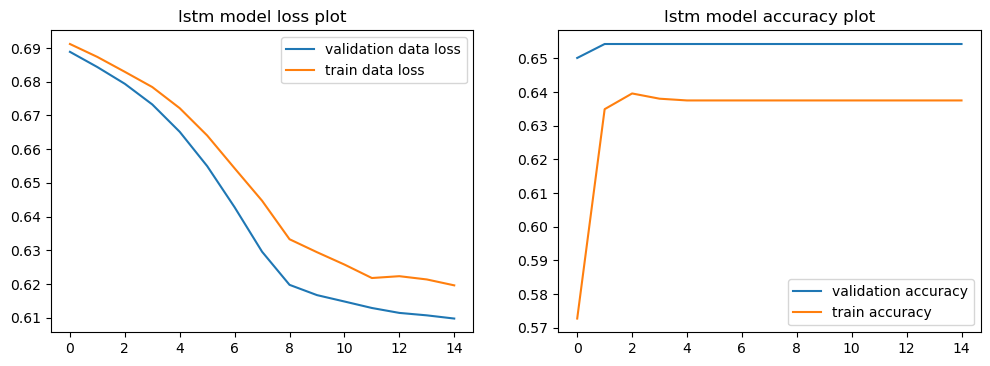

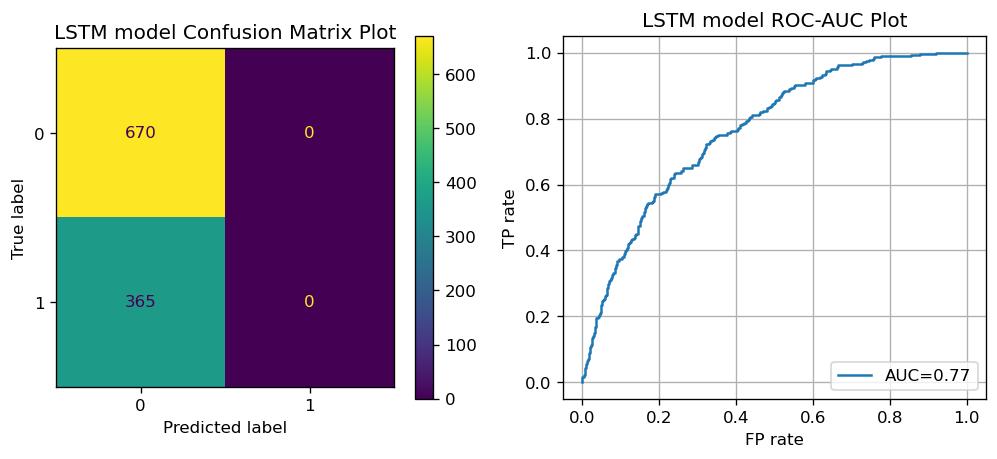

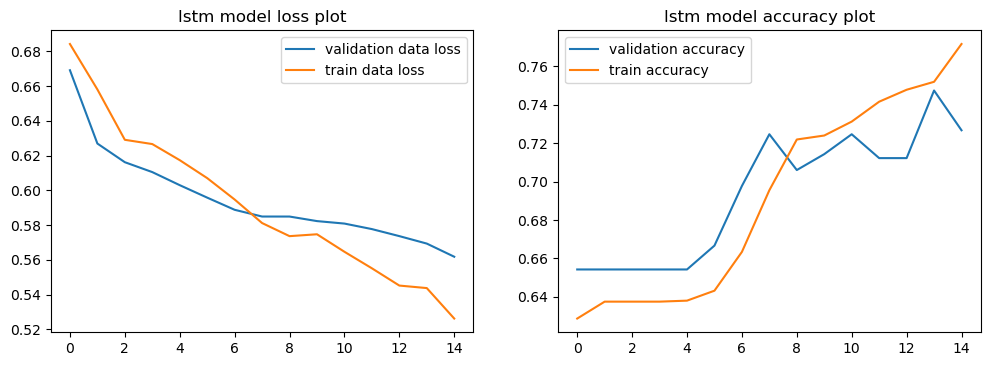

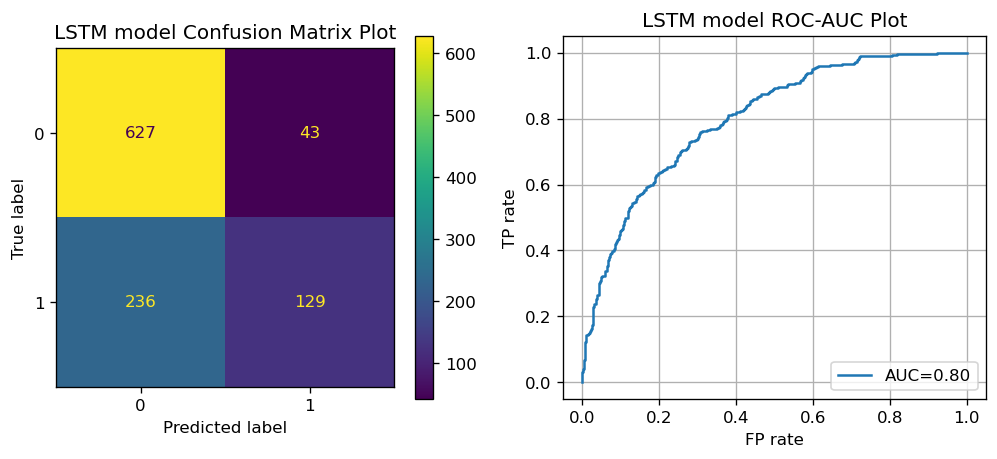

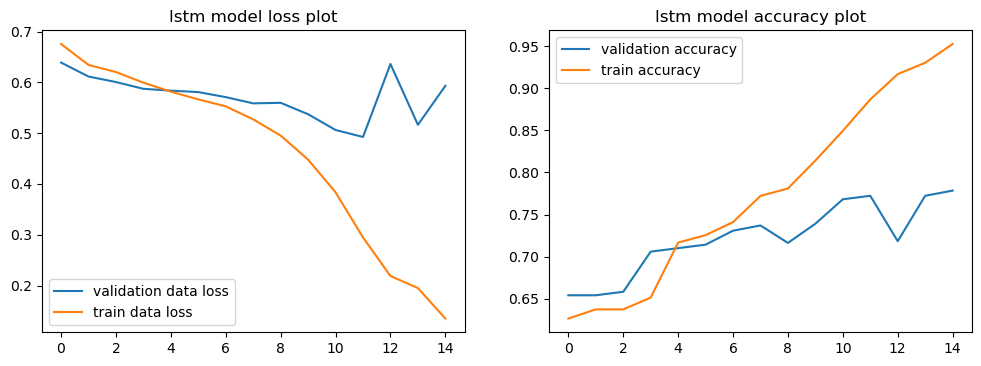

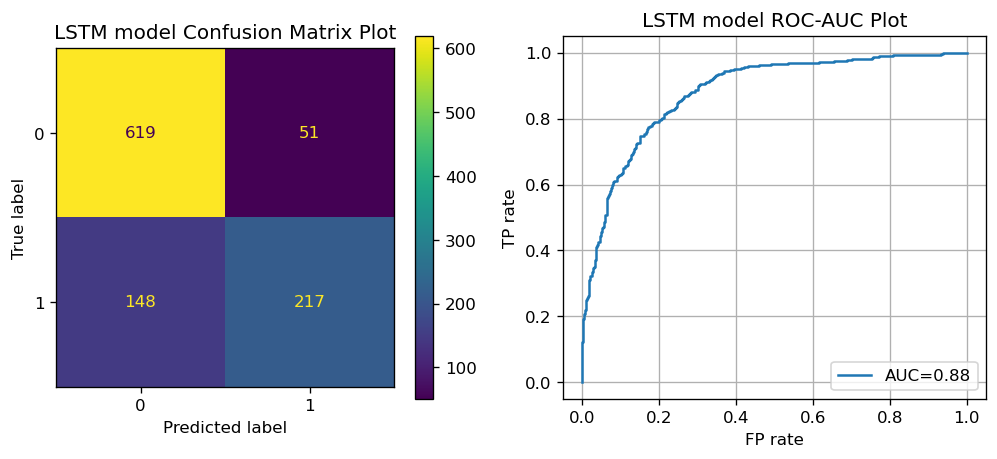

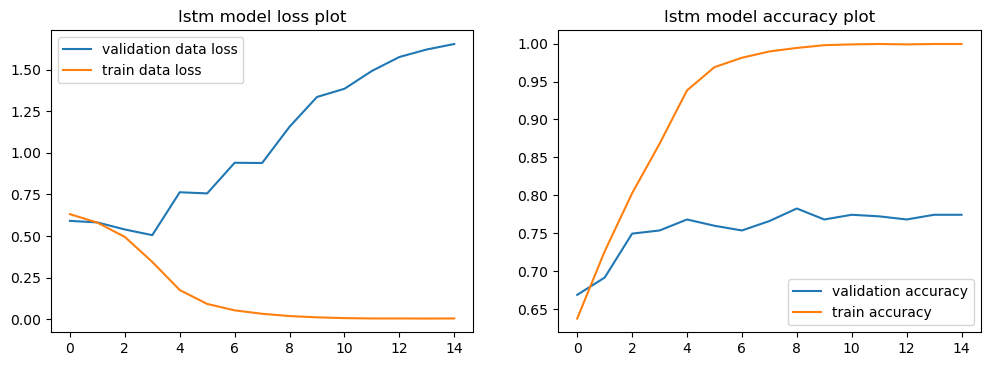

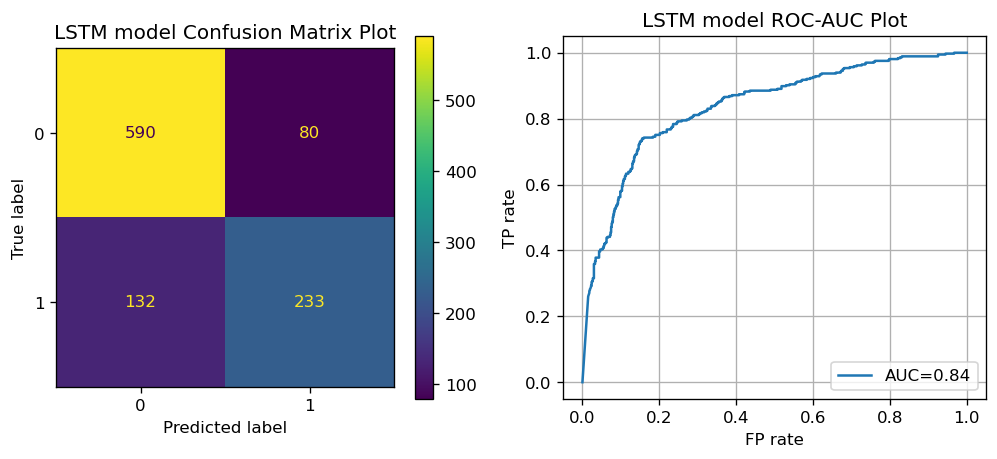

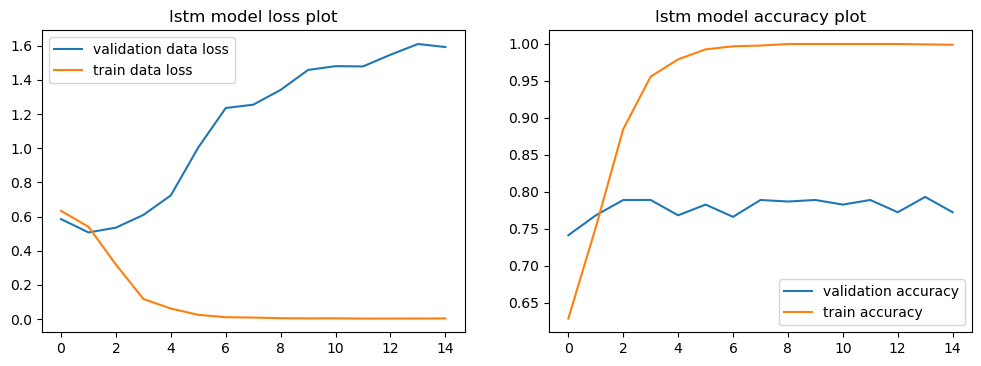

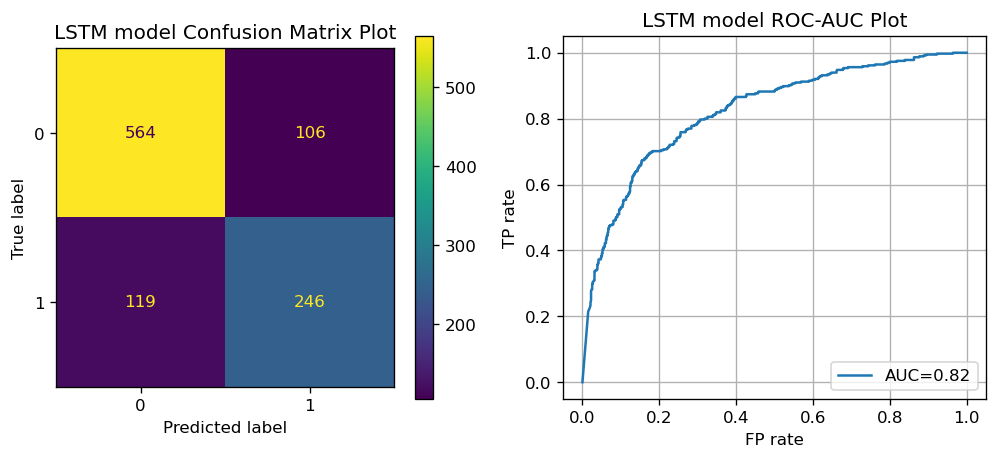

In [245]:
lr_list_lstm = [0.00001,0.00005,0.0001,0.0005,0.001]
lstm_eva_list_ht=[]

for i in range(len(lr_list_lstm)):
    #biuld
    lstm_model = keras.Sequential()
    lstm_model.add(keras.layers.Embedding(len(vocab_ht) + 1, 300, input_length=50))
    lstm_model.add(keras.layers.LSTM(256,return_sequences=True))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.LSTM(256))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.Dense(100, activation='relu'))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

    #compile
    lstm_model.compile(tf.keras.optimizers.Adam(lr=lr_list_lstm[i]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    #train
    lstm_history =lstm_model.fit(X_train_pad_ht, np.array(y_train_ht),
              batch_size=128,
              epochs=15,
              validation_split=0.2)

    #eva
    plot_train('lstm model',lstm_history)
    lstm_eva_list = plot_eva(lstm_model,'LSTM model', X_test_pad_ht, y_test_ht)
    lstm_eva_list_ht.append(lstm_eva_list)

In [247]:
# find best lr
print(pd.DataFrame(lstm_eva_list_ht,columns=['Accuracy','Precision','Recall','F1','AUC']))
print('best lr:',lr_list_lstm[2])

   Accuracy  Precision    Recall        F1       AUC
0  0.647343   0.000000  0.000000  0.392962  0.767070
1  0.730435   0.750000  0.353425  0.649225  0.802204
2  0.807729   0.809701  0.594521  0.773571  0.882224
3  0.795169   0.744409  0.638356  0.767508  0.838665
4  0.782609   0.698864  0.673973  0.759948  0.822210
best lr: 0.0001


Epoch 1/15
16/16 [==============================] - 18s 1s/step - loss: 0.6715 - accuracy: 0.6349 - val_loss: 0.6312 - val_accuracy: 0.6480
Epoch 2/15
16/16 [==============================] - 16s 1s/step - loss: 0.6270 - accuracy: 0.6416 - val_loss: 0.6095 - val_accuracy: 0.6480
Epoch 3/15
16/16 [==============================] - 16s 1s/step - loss: 0.6201 - accuracy: 0.6416 - val_loss: 0.6015 - val_accuracy: 0.6480
Epoch 4/15
16/16 [==============================] - 16s 1s/step - loss: 0.5984 - accuracy: 0.6473 - val_loss: 0.5784 - val_accuracy: 0.6646
Epoch 5/15
16/16 [==============================] - 16s 1s/step - loss: 0.5833 - accuracy: 0.7079 - val_loss: 0.5658 - val_accuracy: 0.7122
Epoch 6/15
16/16 [==============================] - 16s 1s/step - loss: 0.5722 - accuracy: 0.7240 - val_loss: 0.5558 - val_accuracy: 0.7453
Epoch 7/15
16/16 [==============================] - 16s 1s/step - loss: 0.5547 - accuracy: 0.7354 - val_loss: 0.5442 - val_accuracy: 0.7516
Epoch 8/15
16/16 [==

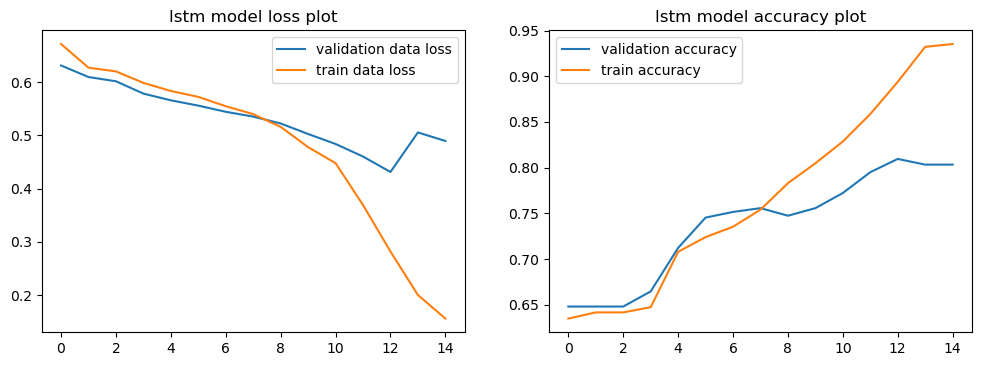

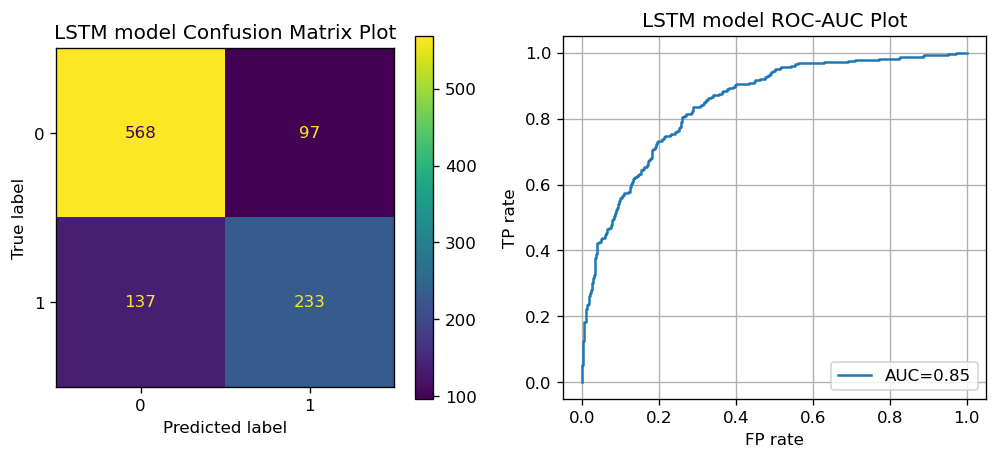

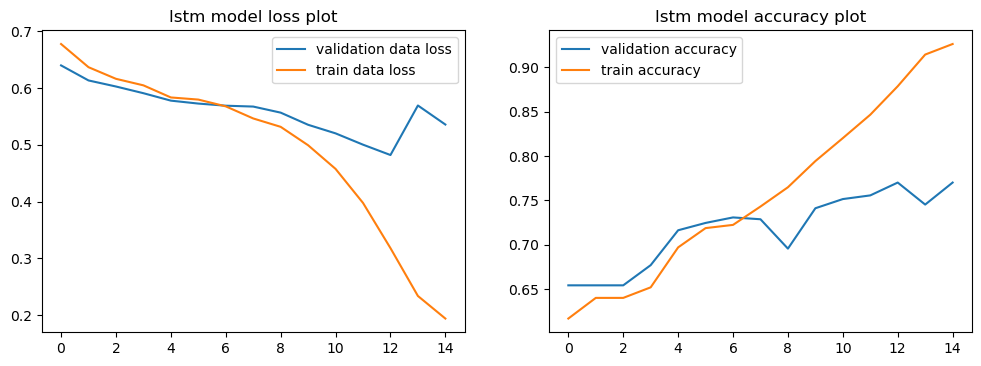

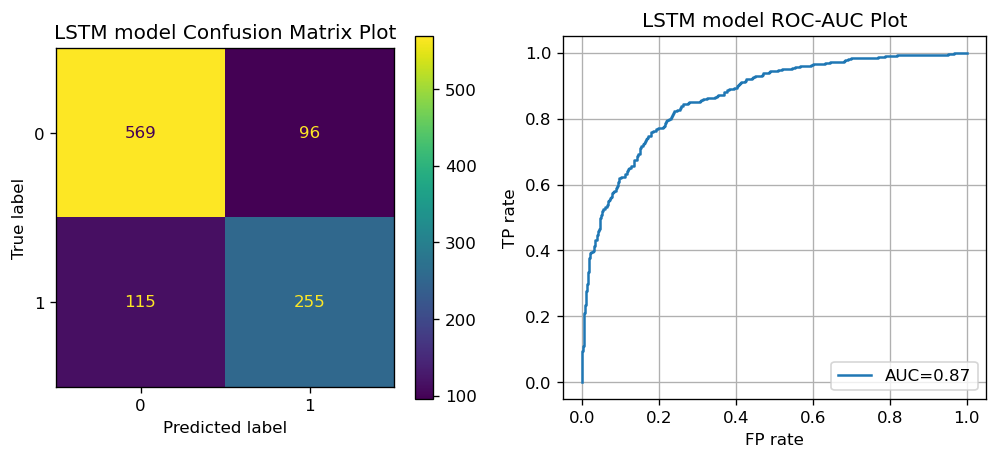

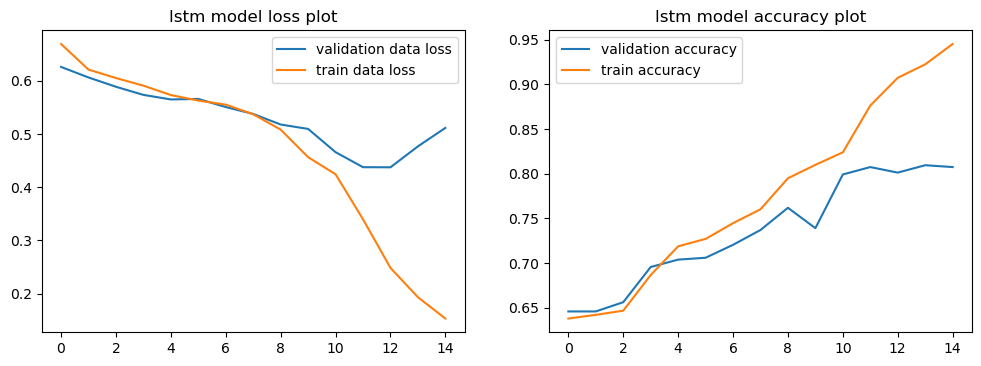

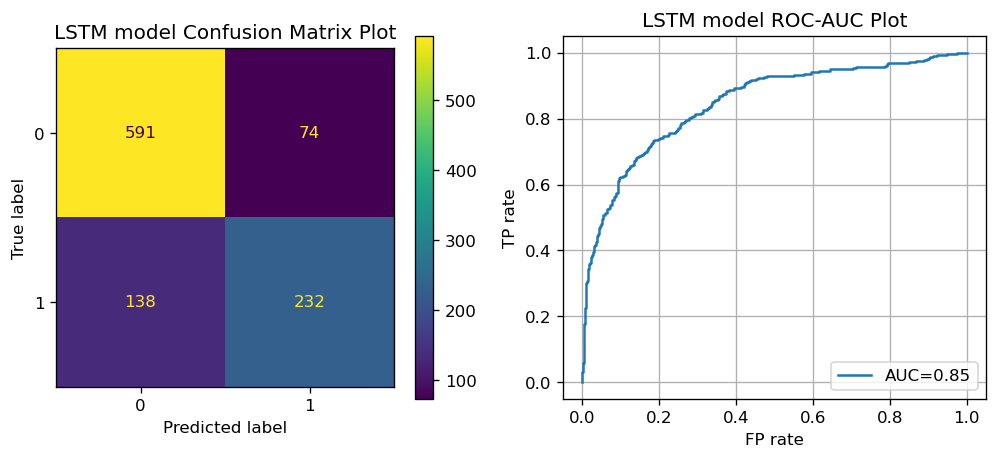

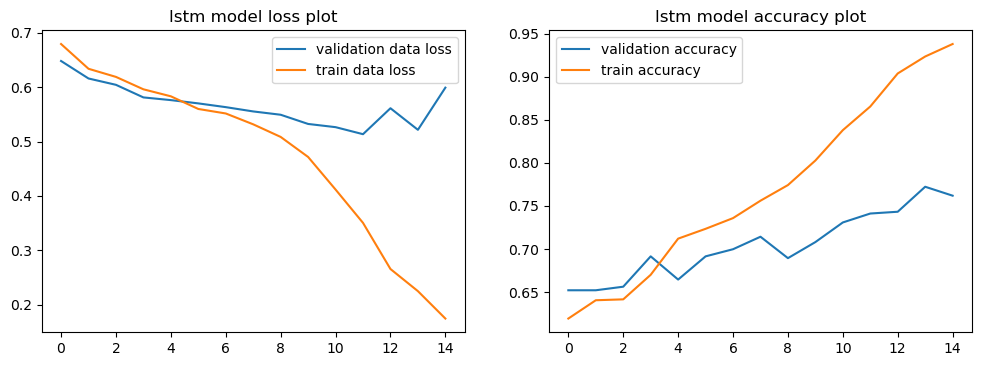

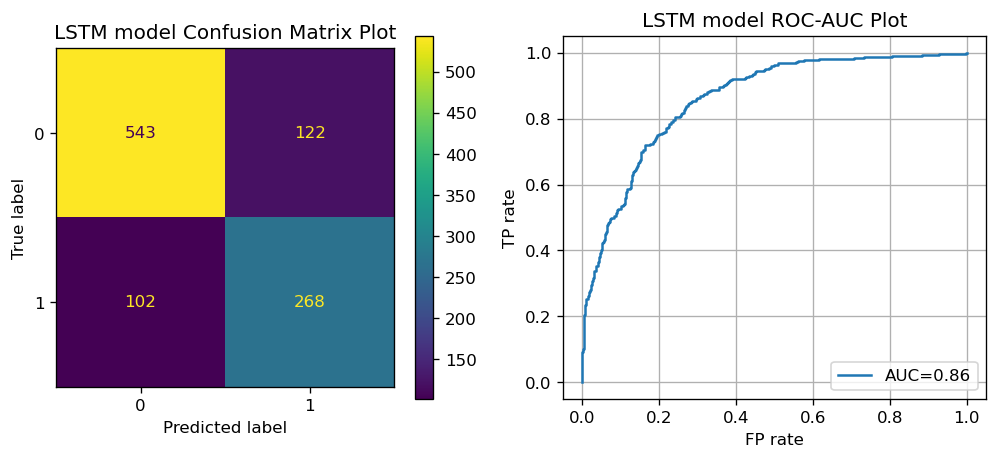

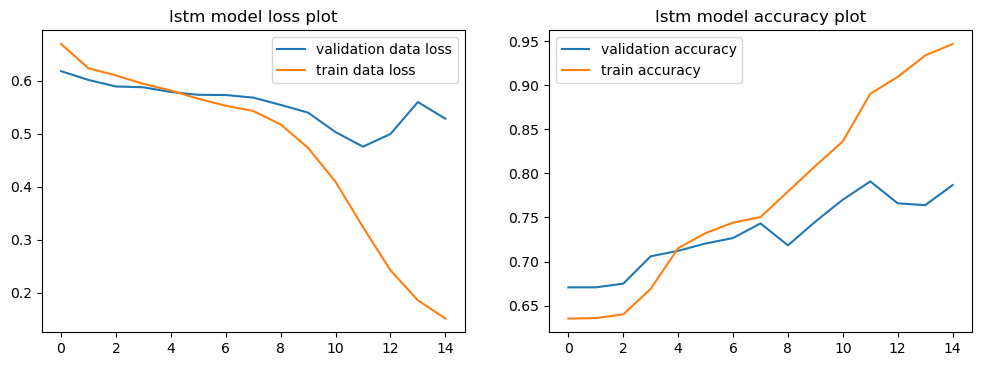

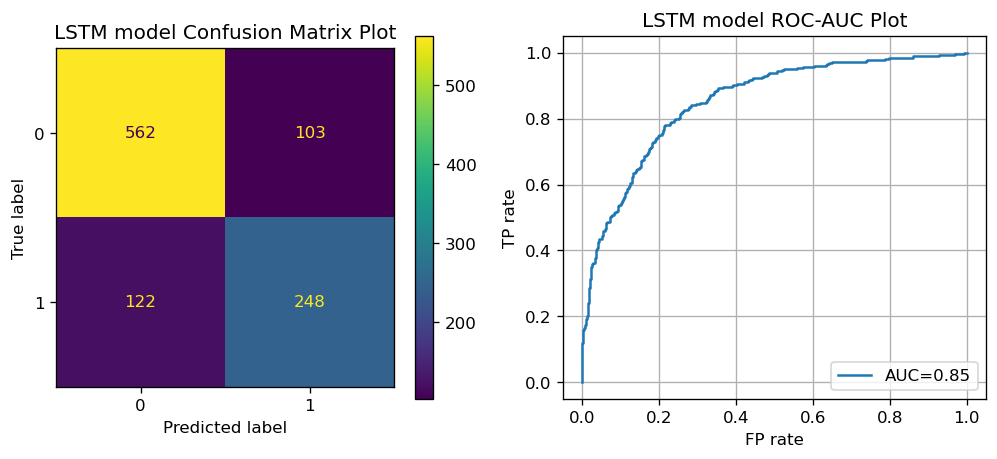

In [250]:
# repeat with best lr
lstm_eva_list_re=[]

for i in range(5):
    vocab,X_train_oh,X_test_oh,X_train_pad,X_test_pad = pad_seq(Tokenizer(split=" "), 
                                                                 X_train_list[i],
                                                                 X_test_list[i], 50,False)
    #build
    lstm_model = keras.Sequential()
    lstm_model.add(keras.layers.Embedding(len(vocab) + 1, 300, input_length=50))
    lstm_model.add(keras.layers.LSTM(256,return_sequences=True))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.LSTM(256))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.Dense(100, activation='relu'))
    lstm_model.add(keras.layers.Dropout(0.4))
    lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))

    #compile
    lstm_model.compile(tf.keras.optimizers.Adam(lr=lr_list_lstm[2]),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    #train
    lstm_history =lstm_model.fit(X_train_pad, np.array(y_train_list[i]),
              batch_size=128,
              epochs=15,
              validation_split=0.2)

    #eva
    plot_train('lstm model',lstm_history)
    lstm_eva_list = plot_eva(lstm_model,'LSTM model', X_test_pad, y_test_list[i])
    lstm_eva_list_re.append(lstm_eva_list)

In [265]:
lstm_re_df = pd.DataFrame(lstm_eva_list_re,columns=['Accuracy','Precision','Recall','F1','AUC'])

print(lstm_re_df.Accuracy.mean(),lstm_re_df.Precision.mean(),lstm_re_df.Recall.mean(),lstm_re_df.F1.mean(),lstm_re_df.AUC.mean())

lstm_re_df.loc[len(lstm_re_df)]=[lstm_re_df.Accuracy.var(),
                                  lstm_re_df.Precision.var(),
                                  lstm_re_df.Recall.var(),
                                  lstm_re_df.F1.var(),
                                  lstm_re_df.AUC.var(),]
cnn_re_df.T

0.7862801932367149 0.7168916921858098 0.6681081081081081 0.7635574300895964 0.8560495834180044


0         1         2         3         4         5
Accuracy   0.757488  0.775845  0.761353  0.746860  0.753623  0.000117
Precision  0.696370  0.707831  0.694006  0.650838  0.698962  0.000497
Recall     0.570270  0.635135  0.594595  0.629730  0.545946  0.001459
F1         0.723686  0.749963  0.730934  0.722439  0.716164  0.000170
AUC        0.807169  0.835038  0.806588  0.811022  0.811583  0.000140

In [84]:
lstm_model._name='LSTM model'
lstm_model.summary()

Model: "LSTM model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 300)           1786200   
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 256)           570368    
_________________________________________________________________
dropout_85 (Dropout)         (None, 50, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_62 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_86 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 1

#### bert+fine tune

In [277]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertModel, DistilBertConfig
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [278]:
def batch_encode(tokenizer, texts, batch_size, max_length):
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
   
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

# split val from train
df_tn,df_val = model_selection.train_test_split(df_train, test_size = 0.2, shuffle = True)

y_tn = df_tn['binary_label'].values.tolist()
y_val = df_val['binary_label'].values.tolist()

X_train_ids, X_train_attention = batch_encode(distilbert_tokenizer, df_tn['text'].values,3000,60)

X_val_ids, X_val_attention = batch_encode(distilbert_tokenizer, df_val['text'].values,3000,60)

# Encode X_test
X_test_ids, X_test_attention = batch_encode(distilbert_tokenizer, df_test['text'].values,3000,60)

In [279]:
# Configure 
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          output_hidden_states=True)
                          
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# embedding layer untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [280]:
def build_model(transformer, max_length=60):

    # Define 
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42) 

    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    cls_token = last_hidden_state[:, 0, :]    

    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  
                                   kernel_constraint=None,
                                   bias_initializer='zeros'
                                   )(cls_token)

    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile
    model.compile(tf.keras.optimizers.Adam(lr=5e-5), 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
bert_model = build_model(distilbert_model)
bert_model.summary()

Model: "functional_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_5 (TFDisti TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 768)]        0           tf_distil_bert_model_

Epoch 1/5
31/31 - 329s - loss: 0.4547 - accuracy: 0.7908 - val_loss: 0.3342 - val_accuracy: 0.8571
Epoch 2/5
31/31 - 319s - loss: 0.2121 - accuracy: 0.9177 - val_loss: 0.3031 - val_accuracy: 0.8696
Epoch 3/5
31/31 - 317s - loss: 0.0699 - accuracy: 0.9782 - val_loss: 0.4493 - val_accuracy: 0.8696
Epoch 4/5
31/31 - 317s - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.5463 - val_accuracy: 0.8696
Epoch 5/5
31/31 - 316s - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.5667 - val_accuracy: 0.8820


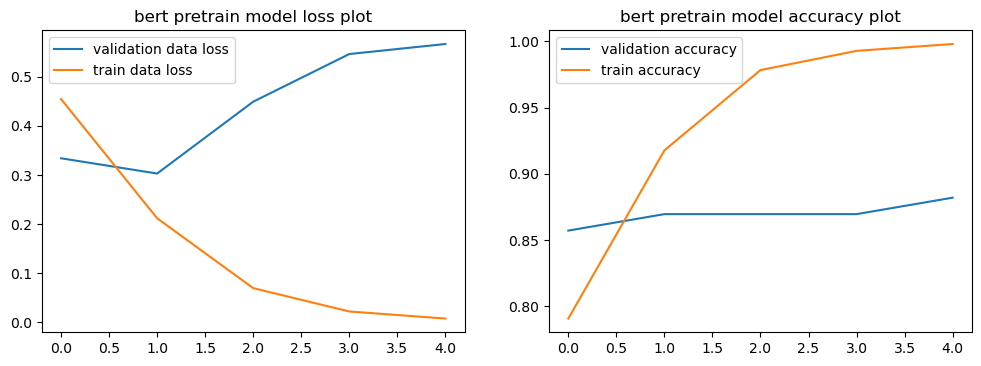

In [281]:
# Train
bert_history = bert_model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_tn),
    epochs = 5,
    batch_size = 64,
    validation_data = ([X_val_ids, X_val_attention], np.array(y_val)),
    verbose=2
)

plot_train('bert pretrain model',bert_history )

Accuracy in test: 0.900
Precision in test: 0.862
Recall in test: 0.862
F1-Score in test: 0.892
auc in test: 0.957


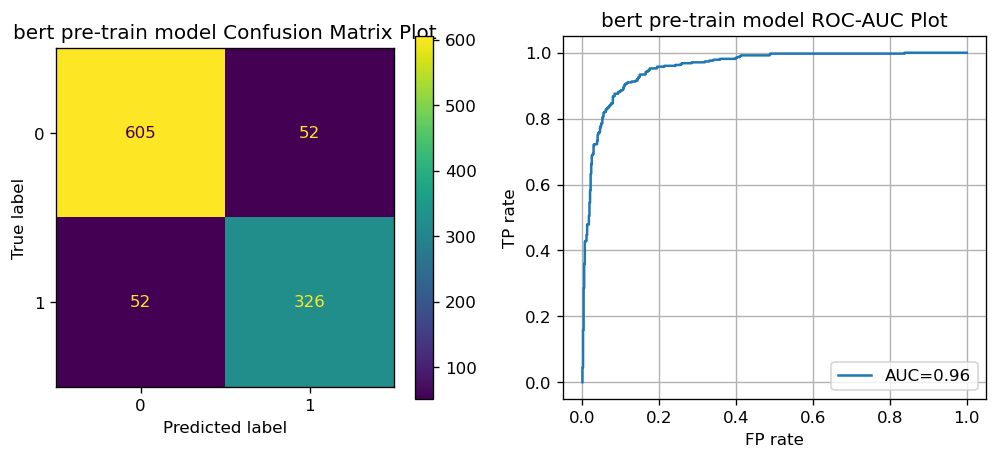

In [282]:
bert_pre_train_eva_list = plot_eva(bert_model,'bert pre-train model',[X_test_ids, X_test_attention], np.array(y_test))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
31/31 - 340s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.8277 - val_accuracy: 0.8737
Epoch 2/3
31/31 - 332s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.8180 - val_accuracy: 0.8737
Epoch 3/3
31/31 - 332s - loss: 7.5644e-05 - accuracy: 1.0000 - val_loss: 0.8396 - val_accuracy: 0.8737


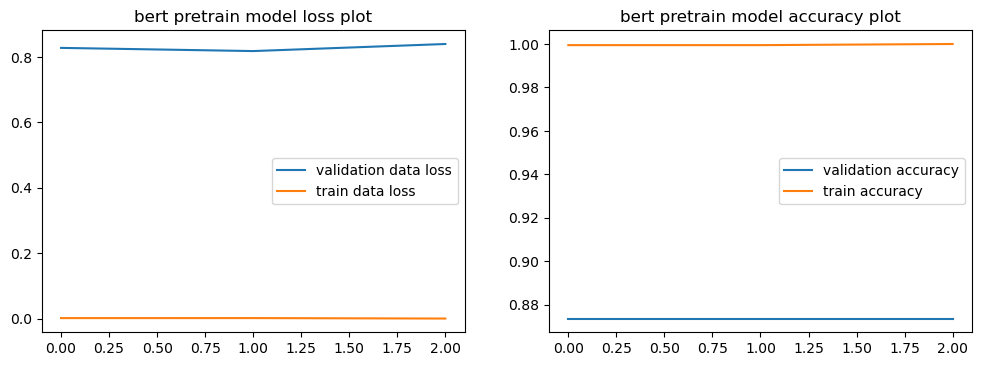

In [283]:
# Configure 
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.2, 
                          output_hidden_states=True)
                          
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

# Unfreeze distilBERT layers
for layer in distilBERT.layers:
    layer.trainable = True
    
# Recompile 
bert_model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train 
ft_bert_history = bert_model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_tn),
    epochs = 3,
    batch_size = 64,
    validation_data = ([X_val_ids, X_val_attention], np.array(y_val)),
    verbose=2
)

plot_train('bert pretrain model',ft_bert_history )

Accuracy in test: 0.894
Precision in test: 0.847
Recall in test: 0.865
F1-Score in test: 0.886
auc in test: 0.958


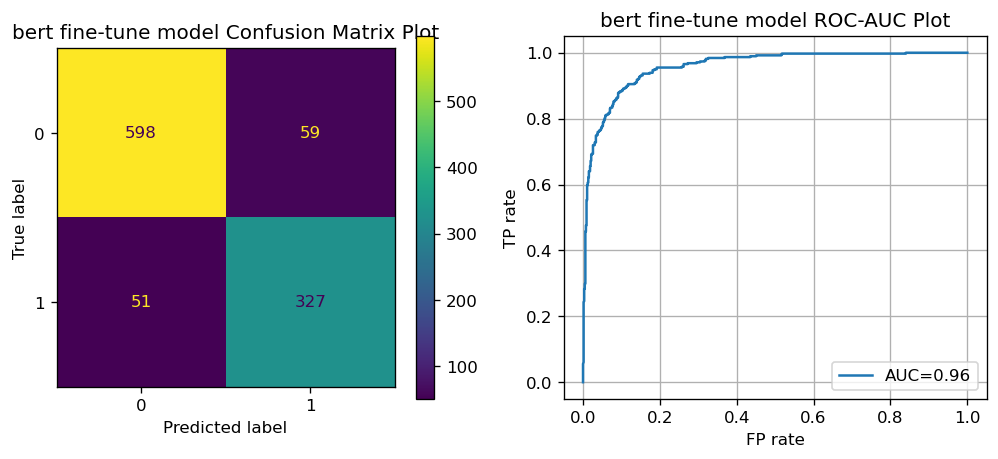

In [284]:
bert_eva_list = plot_eva(bert_model,'bert fine-tune model',[X_test_ids, X_test_attention], np.array(y_test))

In [112]:
bert_model._name='BERT model'
bert_model.summary()

Model: "BERT model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 768)]        0           tf_distil_bert_model[0][